# Yao - View - Unsupervised Time Series Clustering Classification

Below is the description and attachment.  Please complete as soon as possible but at your convenience.

### DESCRIPTION:

Using two or more algorithms, build an unsupervised time series classifier to identify characteristic day-length patterns in the data.

Use appropriate quantitative metrics to determine the number of time series clusters and to evaluate their quality.

In light of the data and the differences between algorithms, speculate on why a given method yielded quantitatively better clusters.

Code should be written in Python or R.

Interactive Notebooks (Jupyter) including code, comments, visualization, and markdown are preferred.

Submissions should be returned 2 weeks from receipt of the data challenge.

## Imports

Libraries and Dataframe. Make sure to install proper libraries and that the dataset exists in the same directory of the extracted zip file.

In [1]:
import sys
try:
    sys.getwindowsversion()
except AttributeError:
    isWindows = False
else:
    isWindows = True
if isWindows:
    import win32api,win32process,win32con
    pid = win32api.GetCurrentProcessId()
    handle = win32api.OpenProcess(win32con.PROCESS_ALL_ACCESS, True, pid)
    win32process.SetPriorityClass(handle, win32process.HIGH_PRIORITY_CLASS)
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, MiniBatchKMeans, SpectralClustering, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import dendrogram,ward
from sklearn.cluster import DBSCAN
from kneed import KneeLocator
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import gc
from IPython.display import Image

%matplotlib inline

## Initial Assumptions 

Given that the (300,000 * 14) dataset is anonymized with 'time' as the time stamp and 'd1' to 'd13' as right-skewed numericals from 0 to ~100,000, one can only assume what the dataset is about for the application of such unsupervised time series clustering task.

Gleaming from the project description, "day-length patterns in the data" suggest that 'time hour' vs 'd1' to 'd13' from the dataset should be plotted against each other, respectively, to gain insight about what the dataset is about before unsupervised clustering. 

One can also gleam that the project is View Inc-related towards something to do with light ray measurement or electrical current activation in the application of light-activated self-automated window tinting when looking at the intensity of 'd1' to 'd13' over time.

Therefore, all further analysis and results from the dataset is regarded as such assumptions for the report to be tangible towards its application process.

In [2]:
df = pd.read_csv(r'.\Data_Challenge_08_2018_to_05_2019.csv', engine='c', low_memory=False, memory_map=True)

df.describe()

d1             d2             d3             d4  \
count  300000.000000  300000.000000  300000.000000  300000.000000   
mean     3738.550417    3349.657543    4371.751347    5970.366247   
std      5436.596255    4815.470873    6937.941155   10735.350198   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       4.000000       0.000000       7.000000   
75%      6527.000000    5871.000000    6766.000000    7524.000000   
max     36334.000000   37334.000000   51027.000000   77352.000000   

                  d5             d6             d7             d8  \
count  300000.000000  300000.000000  300000.000000  300000.000000   
mean     8296.508277    9833.254293   11263.302223    9529.290507   
std     15558.262381   18109.127336   20384.007902   17039.236355   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000      19.000000       0.000000       0.000000   
75%      8962.000000   10627.000000   13485.000000   12587.000000   
max     98679.000000   98694.000000   98697.000000   98697.000000   

                  d9            d10            d11            d12  \
count  300000.000000  300000.000000  300000.000000  300000.000000   
mean     9321.631163    8163.769003    6876.996547    5168.346233   
std     16885.938220   14481.354529   12511.361157    8656.883367   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         7.000000      10.000000       1.000000       0.000000   
75%     11545.000000    9853.000000    8968.000000    7889.750000   
max     98703.000000   87656.000000   84114.000000   72609.000000   

                 d13  
count  300000.000000  
mean    10645.341623  
std     17701.523190  
min         0.000000  
25%         7.000000  
50%        34.000000  
75%     15352.000000  
max     98685.000000

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 14 columns):
time    300000 non-null object
d1      300000 non-null int64
d2      300000 non-null int64
d3      300000 non-null int64
d4      300000 non-null int64
d5      300000 non-null int64
d6      300000 non-null int64
d7      300000 non-null int64
d8      300000 non-null int64
d9      300000 non-null int64
d10     300000 non-null int64
d11     300000 non-null int64
d12     300000 non-null int64
d13     300000 non-null int64
dtypes: int64(13), object(1)
memory usage: 32.0+ MB


In [4]:
df.shape

(300000, 14)

## Time Series Feature Engineering

To make more features from the data given, the time stamp is split to 'date' and 'time hour', where 'time hour' from 'HH:MM:SS' format is converted into decimal format on a 24-hour scale. 

The conversion from datetime to numerical is necessary for various algorithms to take in such time series data without the dataset losing data integrity.

The days of the week, where Monday is 1 to where Sunday is 7 also extracted as 'weekday'. Days of the week (1 to 7 scale) instead of days of the month (1 to 31 scale) is extracted because days of the month is arbitrary because day '1' of the month falls on different weekdays of different months. 

Also, due to the assumptions discussed that the dataset measures light ray or electrical current intensity, all data are better grouped by Mondays to Fridays as "weekdays" and Saturday and Sunday as "weekends" assuming that the building is an office and light variation scheduling (especially of exterior artificial ambient light) may differ on the weekends due to internal building energy conservation or exterior light pollution.

Because days of the week from 1 to 7 brings more insight, 'week number' from 1 to 52, signifying weeks of the calendar year is extracted instead of "Month" of the datetime because month measurement is arbitrary because month length can vary from 4 weeks (i.e. February 2015) to 6 weeks (i.e. December 2018) depending on what weekday a month starts at.

As a fail-safe, ordinal linux time of the original time stamp is also extracted to keep month, day, time to the exact second kept into one column instead of multiple columns in the event that dimensionality reduction were to remove certain extracted columns of the time stamp and not others.

Non-numerical columns are then removed from the dataset once their numerical counterparts are extracted.

In [5]:
df['date'], df['time hour'] = df['time'].str.split(' ', 1).str
df['time hour']= df['time hour'].str.split(':').apply(lambda x: int(x[0]) + int(x[1])/60)

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['weekday'] = df['date'].dt.dayofweek + 1

df['weekend'] = np.where(df['weekday'] > 5, 1, 0)
df['weeknumber']=df['date'].dt.week
df['month']=df['date'].dt.month

df['time'] = pd.to_datetime(df['time'])
df['ordinal'] = df['time']
df['ordinal'] = df['ordinal'].apply(lambda v: v.timestamp())

df = df.drop(columns=['date','time'])

## D1 to D13 Feature Engineering

Under the assumptions discussed that the d1 to d13 dataset measures light ray or electrical current intensity, the row-mean and row-median are calculated because of the time-sensitivity per row. Mean suggest the average intensity measurement of the 13 windows and median suggest the skewity of the intensity measurement of the 13 windows.

Adding min, max, 25 percentile and 75 percentile of each row may be overkill because there may be too much collinearity among features.

The current state of the dataframe looks as follows:

In [6]:
d_columns = ['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11', 'd12', 'd13']

df['d_mean'] = df[d_columns].mean(axis=1)
df['d_median'] = df[d_columns].median(axis=1)

d_columns.extend(('d_mean', 'd_median'))

In [7]:
df

d1     d2     d3     d4     d5     d6     d7     d8     d9    d10  \
0       22174  21869  26379  30271  35230  38576  44098  37217  37842  33345   
1       21518  21153  25071  28526  33035  35939  40760  34443  35513  31996   
2       20494  19678  23887  27213  31518  34129  38508  32454  33485  30268   
3       20947  20322  24851  28464  33044  35782  40251  33682  34425  30824   
4       21920  21264  26107  29688  34419  37280  42022  35247  36099  32316   
5       22213  21088  25944  29682  34437  37327  42165  35505  36537  32809   
6       21491  20429  25064  28540  33035  35772  40422  34081  35135  31621   
7       20863  19832  24307  27638  31999  34597  38995  32834  33886  30590   
8       20174  19150  23403  26546  30905  33428  37676  31712  32736  29531   
9       18805  17920  22002  25014  29077  31416  35337  29691  30602  27579   
10      18689  17850  21751  24671  28491  30667  34383  28828  29645  26701   
11      18551  17569  21355  24195  27993  30207  33981  28597  29518  26703   
12      16702  16234  19678  22255  25760  27775  31259  26304  27195  24591   
13      15533  15065  18373  20755  23971  25783  28911  24280  25083  22703   
14      14914  14387  17566  19808  22902  24642  27626  23174  23920  21639   
15      14041  13530  16494  18594  21506  23160  25968  21795  22485  20322   
16      13648  13130  16174  18193  21035  22618  25337  21216  21857  19748   
17      13687  12974  16125  18169  21050  22681  25467  21373  22047  19934   
18      12748  12068  14947  16828  19518  21047  23672  19916  20580  18630   
19      12204  11612  14427  16237  18826  20240  22651  18974  19535  17621   
20      12536  11992  14959  16917  19651  21195  23712  19814  20325  18267   
21      12560  11977  14947  16908  19678  21258  23902  20074  20651  18563   
22      12397  11862  14787  16711  19434  20986  23588  19814  20400  18340   
23      12461  11776  14669  16530  19255  20826  23479  19784  20452  18440   
24      11858  11198  13932  15717  18361  19893  22482  18992  19672  17760   
25      11237  10574  13149  14810  17328  18775  21216  17911  18563  16772   
26      10340   9740  12074  13639  15983  17403  19693  16678  17270  15603   
27       9312   8814  10923  12382  14512  15820  17835  15083  15536  14030   
28       8781   8376  10473  11962  14086  15382  17301  14551  14874  13319   
29       8575   8219  10317  11823  13953  15240  17153  14415  14684  13083   
...       ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
299970      0      0      0      4      0     13      0      0      7      7   
299971      0      0      0      7      0      7      0      0      7      1   
299972      0      0      0      7      0     10      0      0      5      7   
299973      0      0      0      5      0     10      0      0      1      5   
299974      0      0      0      1      0      7      0      0      1      7   
299975      0      0      0      0      0     10      0      0      0      7   
299976      0      0      0      7      0     10      0      0      4      7   
299977      0      0      0      4      0      7      0      0      5      4   
299978      0      0      0      0      0      7      0      0      1      0   
299979      0      0      0      4      0     13      0      0      4      7   
299980      0      0      0      0      0     10      0      0      4      0   
299981      0      0      0      1      0      7      0      0      4      1   
299982      0      1      0      0      0      7      0      0      1      1   
299983      0      0      0      0      0      7      0      0      7      4   
299984      0      0      0      7      0      7      0      0      5      4   
299985      0      0      0      4      0     10      0      0      4      7   
299986      0      0      0      1      0     10      0      0      7      7   
299987      0      0      0      0      0     10      0      0      4      5   
299988     

## Group-by View: 'd1' to 'd13' intensities per 'time hour'

Another dataframe is created for a group-by view of 'd1' to 'd13' intensities per 'time hour' regardless of day of week and week number. 

Because the data collection has imperfect intervals and varies on the second-scale, the dataset is round to the first decimal to capture intensity by the time hour.

In [8]:
df2= df.drop(columns=['ordinal','weekend']).round(1)

In [9]:
df3 = df2.drop(columns=['weekday','weeknumber']).groupby(['time hour']).mean()
df3

d1        d2        d3        d4        d5        d6   d7  \
time hour                                                                    
0.0        0.000000  0.060459  0.000000  0.494559  0.000000  3.492140  0.0   
0.1        0.000000  0.092144  0.000000  0.514064  0.000970  3.435500  0.0   
0.2        0.000691  0.064271  0.000691  0.472011  0.000691  3.270905  0.0   
0.3        0.000000  0.092323  0.000000  0.487852  0.000000  3.317784  0.0   
0.4        0.000000  0.094810  0.000000  0.455363  0.000692  3.316263  0.0   
0.5        0.000000  0.087041  0.000967  0.417795  0.000967  3.072534  0.0   
0.6        0.000000  0.077295  0.000000  0.459627  0.001380  3.118703  0.0   
0.7        0.000000  0.072604  0.000968  0.394966  0.001936  3.089061  0.0   
0.8        0.000692  0.089273  0.000000  0.503806  0.000692  3.304498  0.0   
0.9        0.000000  0.114010  0.000000  0.568116  0.000000  3.327536  0.0   
1.0        0.000693  0.063800  0.000693  0.472954  0.001387  3.279473  0.0   
1.1        0.000000  0.095468  0.000000  0.482160  0.000000  3.061716  0.0   
1.2        0.000689  0.082645  0.000689  0.458678  0.002066  3.097107  0.0   
1.3        0.000000  0.087753  0.000000  0.452266  0.000964  3.017358  0.0   
1.4        0.000000  0.088215  0.000689  0.423846  0.000000  3.049621  0.0   
1.5        0.000000  0.082852  0.000963  0.465318  0.001927  3.130058  0.0   
1.6        0.000689  0.087526  0.000000  0.454859  0.002068  3.192970  0.0   
1.7        0.000000  0.094503  0.000964  0.485053  0.001929  3.204436  0.0   
1.8        0.002749  0.075601  0.001375  0.456357  0.001375  3.193814  0.0   
1.9        0.000000  0.085024  0.000966  0.446377  0.000966  3.013527  0.0   
2.0        0.000000  0.067082  0.000000  0.459889  0.001383  3.114799  0.0   
2.1        0.000000  0.091965  0.000968  0.448209  0.000000  3.171346  0.0   
2.2        0.000691  0.099448  0.000691  0.443370  0.004144  3.160912  0.0   
2.3        0.000000  0.087041  0.000967  0.433269  0.000000  3.207930  0.0   
2.4        0.000000  0.087318  0.000693  0.467775  0.002772  3.124047  0.0   
2.5        0.000000  0.060019  0.000000  0.382381  0.000968  3.158761  0.0   
2.6        0.000000  0.076763  0.000692  0.421853  0.000000  2.992393  0.0   
2.7        0.000000  0.107558  0.000000  0.400194  0.000969  2.953488  0.0   
2.8        0.000000  0.082001  0.000000  0.432940  0.000695  2.826268  0.0   
2.9        0.000000  0.061047  0.003876  0.437016  0.000000  2.897287  0.0   
...             ...       ...       ...       ...       ...       ...  ...   
21.1       0.000000  0.100575  0.003831  0.872605  0.021073  4.062261  0.0   
21.2       0.000000  0.116564  0.000000  0.937969  0.014997  4.042945  0.0   
21.3       0.000000  0.098376  0.000000  0.841452  0.016237  3.882521  0.0   
21.4       0.000000  0.124487  0.000000  0.931601  0.021888  3.889877  0.0   
21.5       0.000000  0.105973  0.000000  0.870906  0.016378  3.928709  0.0   
21.6       0.001374  0.130495  0.000000  0.800824  0.013049  3.853709  0.0   
21.7       0.001919  0.107486  0.000000  0.831094  0.013436  3.903071  0.0   
21.8       0.000000  0.104795  0.000000  0.821233  0.011644  3.839041  0.0   
21.9       0.000000  0.182868  0.000962  0.865255  0.010587  3.897016  0.0   
22.0       0.000000  0.122519  0.000000  0.822724  0.003422  3.793292  0.0   
22.1       0.000000  0.155172  0.000958  0.847701  0.015326  3.793103  0.0   
22.2       0.001372  0.120713  0.000000  0.807270  0.006859  3.898491  0.0   
22.3       0.000961  0.127762  0.001921  0.779059  0.003842  3.874159  0.0   
22.4       0.000000  0.120548  0.000685  0.750685  0.010274  3.840411  0.0   
22.5       0.000000  0.126679  0.000000  0.743762  0.004798  3.634357  0.0   
22.6       0.000685  0.116518  0.000000  0.701851  0.002742  3.569568  0.0   
22.7       0.000000  0.099229  0.000000  0.702312  0.003854  3.636802  0.0   
22.8       0.000000  0.148658  0.000000  0.741225  0.003441  3.735031  0.0   
22.9       0.000000  0.100193  0.000000

## Plotting Group-by View: 'd1' to 'd13' intensities per 'time hour'

When all the 'd1' to 'd13' intensities per 'time hour' are plotted on the same plot, the peaks and intensity ranges are different.

As assumed about the nature of the dataset, sun rise is around 6:20 AM and sunset is around 8:00 PM when the mean and median intensities are plotted, which shows a normal distribution for both. This normal distribution suggests that the building has installed windows on all sides; otherwise, the distribution would be skewed towards the cardinal direction that has more installed windows.

The different shapes of the intensity graphs suggest that the window orientation may be different in relation to how the sun travels.

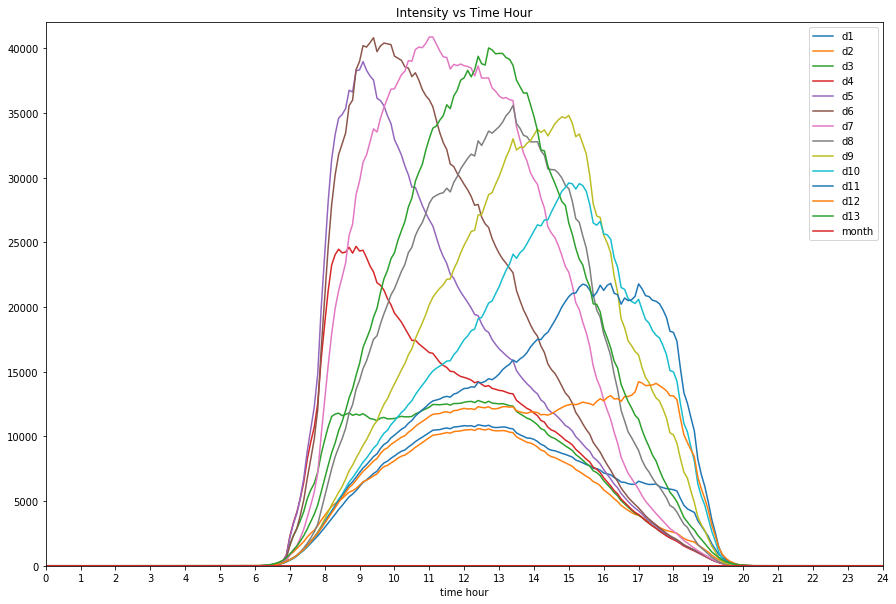

In [10]:
df3.drop(columns=['d_mean','d_median']).plot(figsize=(15,10), title='Intensity vs Time Hour',xticks=range(0,25),ylim =(0, 42000));

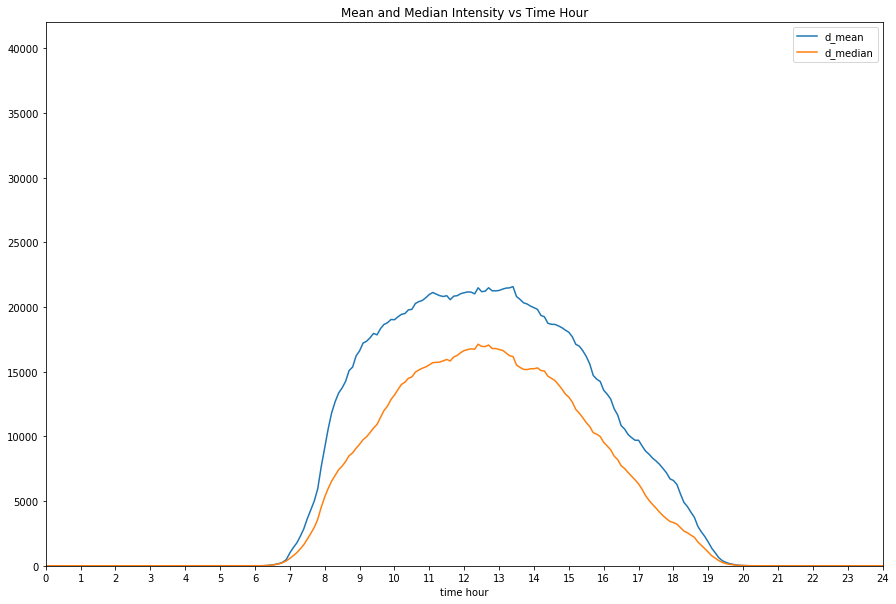

In [11]:
df3[['d_mean','d_median']].plot(figsize=(15,10), title='Mean and Median Intensity vs Time Hour',xticks=range(0,25),ylim =(0, 42000));

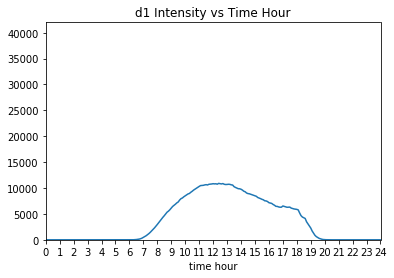

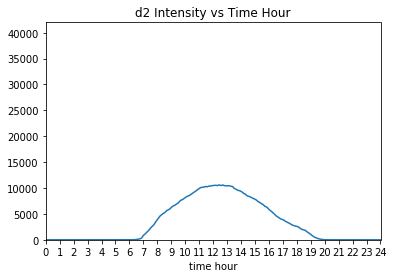

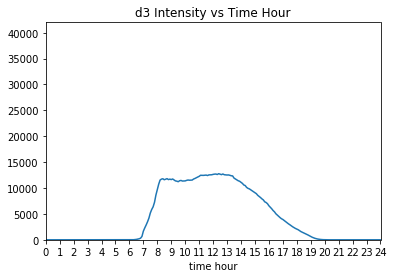

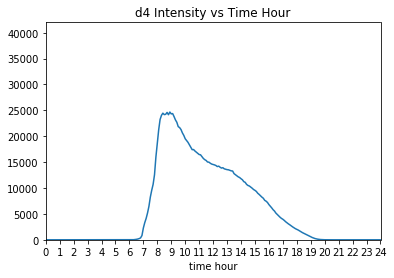

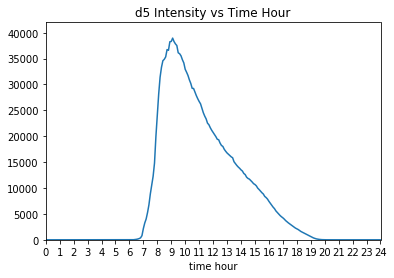

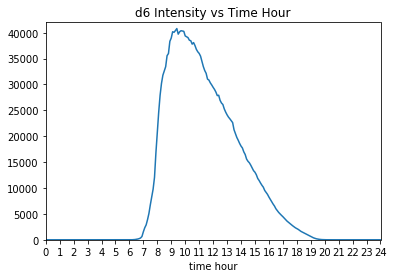

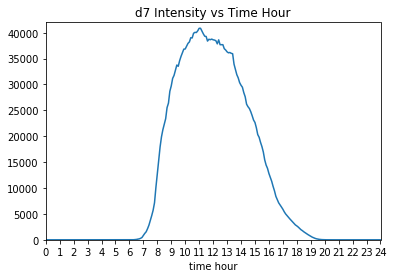

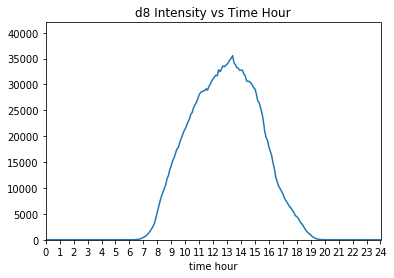

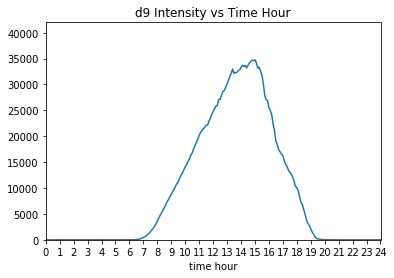

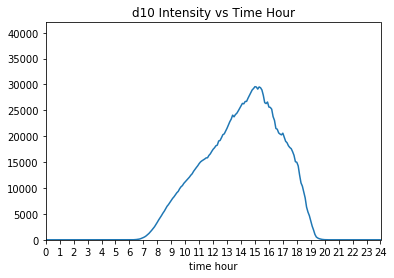

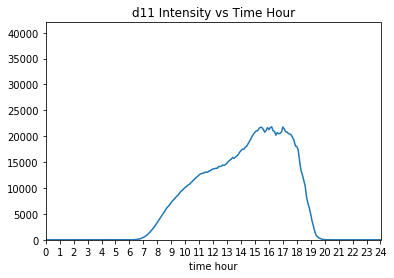

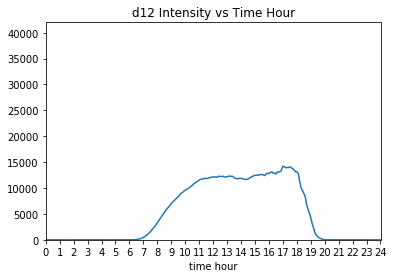

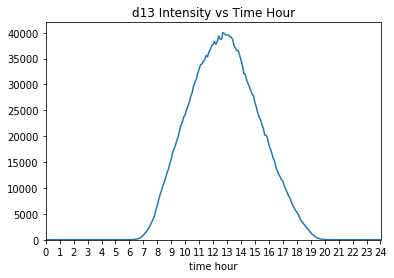

In [12]:
timecolumns = df3.drop(columns=['d_mean','d_median', 'month']).columns

for i in timecolumns:
    df3[i].plot(title = i+' Intensity vs Time Hour', ylim =(0, 42000),xticks=range(0,25));
    plt.show()

## Speculation of dataset

Assuming that the d1 to d13 intensities are differently orientated windows and that the building is in the northern hemisphere, the sun's intensity is dependent on time of day and week of year, where the sun is closer to the Tropic of Cancer in the summer time and the sun is further towards the Tropic of Capricorn in the winter time.

This means not only does d1 to d13 intensity have a sinusoidal relationship with 'time hour' with the peak at noon and the nadir at midnight, they also have a sinusoidal relationship with 'week of the year' with the peak at June and the nadir at December.

Looking at the d1 to d13 intensities separately with the same y-axis range:

* D5 and D6 have a high intensity peak around 9 AM and diminishes over the course of the day and could be southeastern facing windows.

* D7, D8 and D13 have a normal distribution with a high intensity peak, which could be southern/overhead facing windows.

* D1, D2, D3, and D12 have a normal distribution with a low intensity peak, which could be northern facing windows.

* D4 have a peak around 9 AM and low intensity, which could be an eastern facing window.

* D9 and D10 have a high intensity later during the day, which could be western facing windows.

* D11 has a low intensity with a peak later during the day, which could be a northwestern facing window.

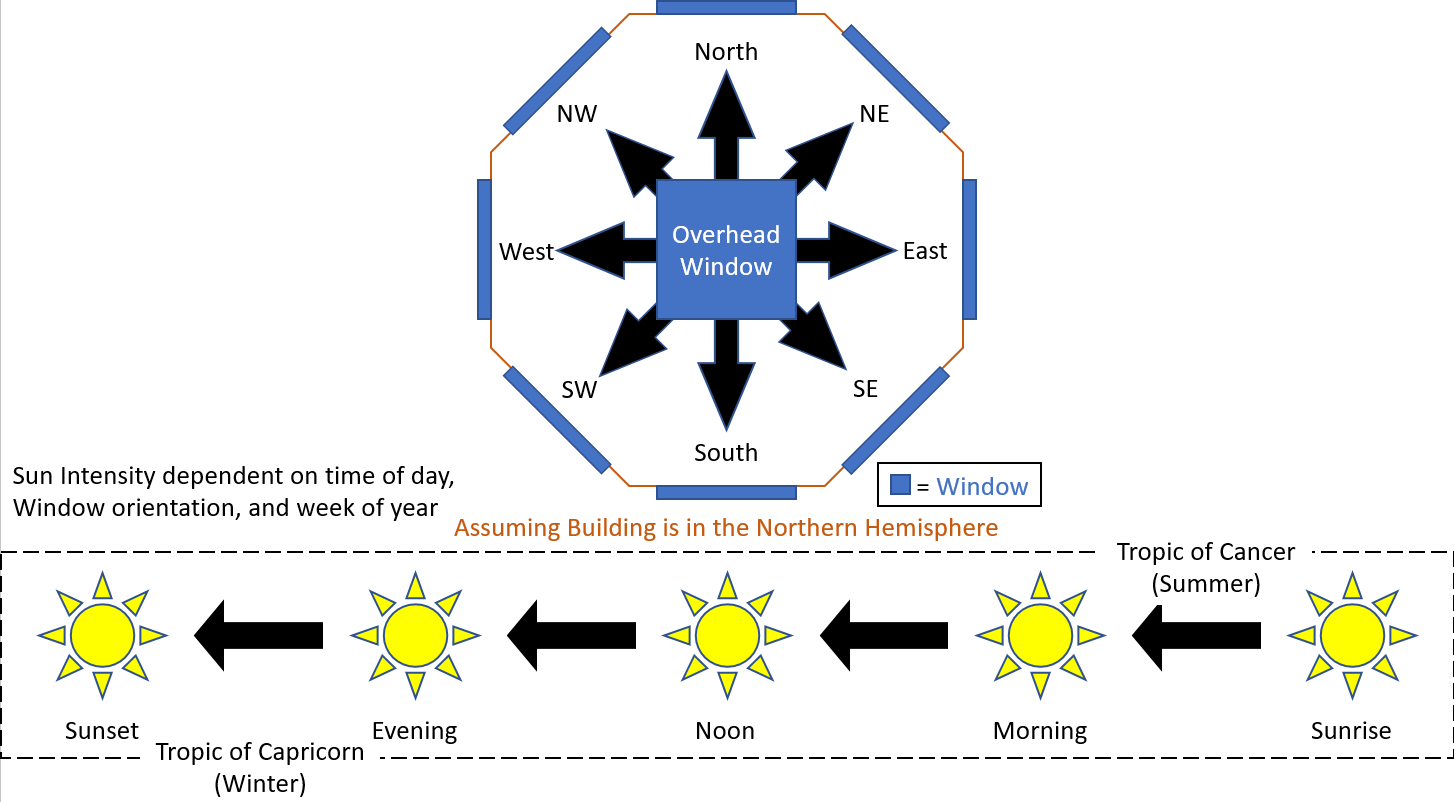

In [13]:
Image(filename="./sun.png")

## Plotting Group-by View: 'd1' to 'd13' intensities per 'time hour' and 'weekday'

When hours of the day are grouped by the day of the week, Wednesday seems to have the least intensity and Thursday seem to have the highest intensity.

If the dataset was actually measuring light rays or electrical current, the disparity between days of the week and intensity should not be this great. It might be due to scheduled tree trimming on Wednesdays or unknown auxiliary variables that would induce intensity discrepancies between days of the week.

In [14]:
df4 = df2.drop(columns=['weeknumber', 'month']).groupby(['time hour','weekday']).mean().reset_index().set_index('time hour')

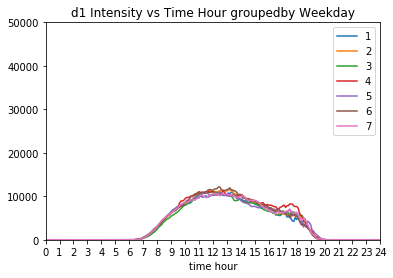

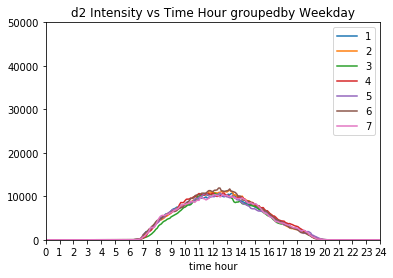

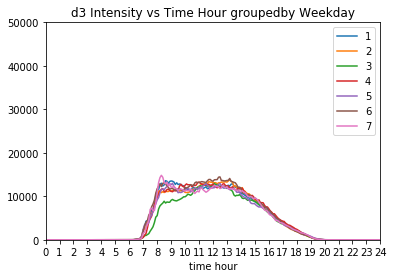

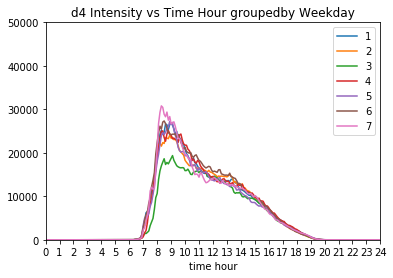

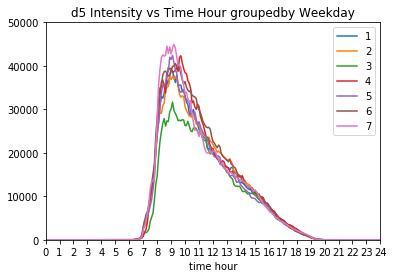

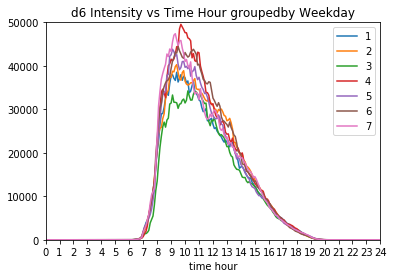

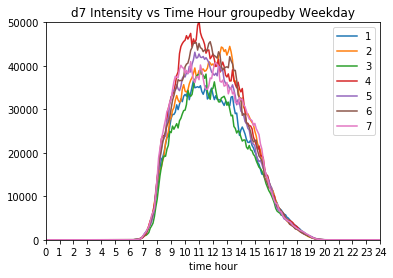

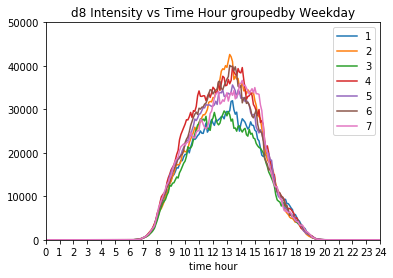

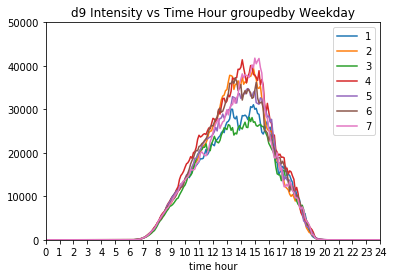

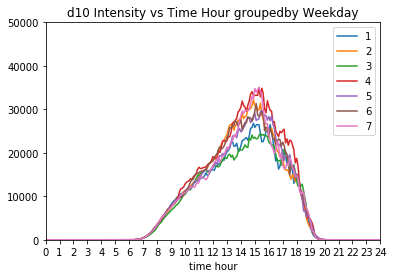

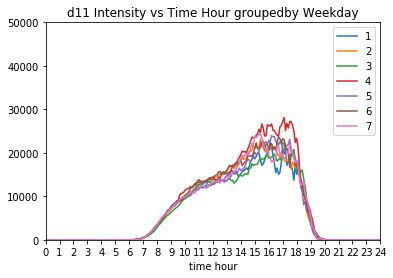

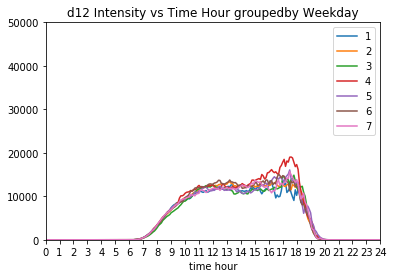

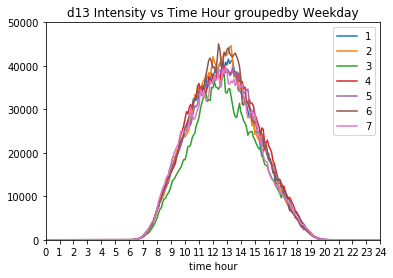

In [15]:
for i in timecolumns:
    df4.groupby('weekday')[i].plot(legend=True,title = i+' Intensity vs Time Hour groupedby Weekday', ylim =(0, 50000),xticks=range(0,25));
    plt.show()

## Plotting Group-by View: 'd1' to 'd13' intensities per 'time hour' and 'Month'

For the sake of plotting, Month because there are 12 of them vs 52 weeks. The model is fed 'week of the year' and 'month' is only used for plotting purposes.

When hours of the day are grouped by month, October seems to have the least intensity and September seem to have the highest intensity. December's time range is the least while August's time range is the greatest (June's month does not exist).

If the dataset was actually measuring light rays or electrical current, the disparity between month and intensity should be explained away by Summer and Winter solstices. The Summer and Winter solstices does explain the time range of intensity between supposed sunrise and sunset.

Again, unknown auxiliary variables would induce intensity discrepancies between months such as reflection of light due to snow as well as lack of leaves on trees, creating higher intensities during the winter months.

Also note that March's data abruptly ends at 1PM in 2019 (even after the groupby mean), meaning that the dataset is relatively new.

In [16]:
df5 = df2.drop(columns=['weekday']).groupby(['time hour','month']).mean().reset_index().astype(float).set_index('time hour')

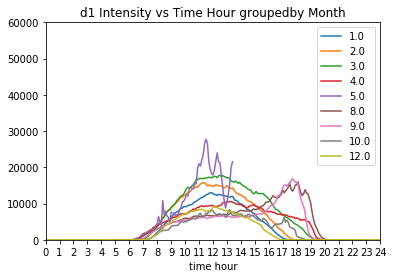

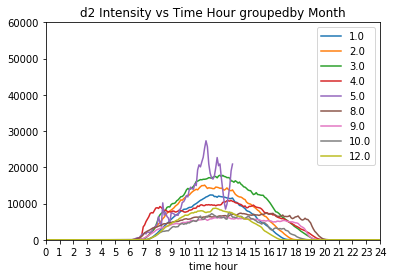

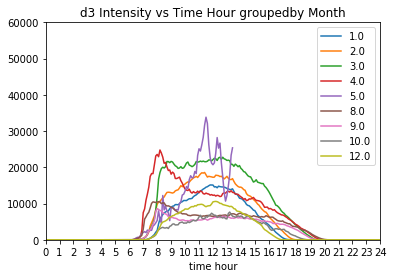

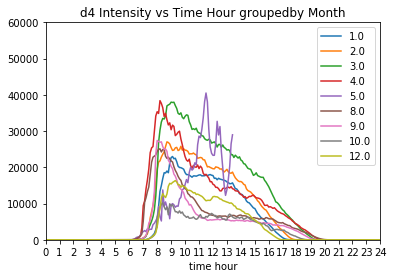

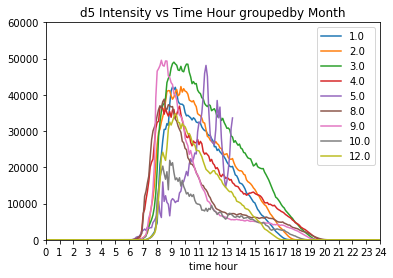

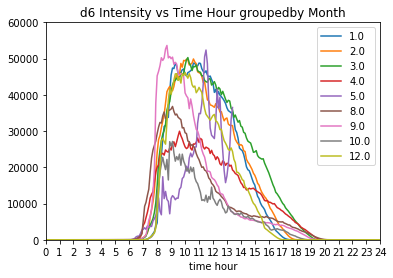

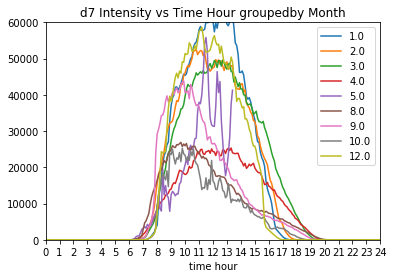

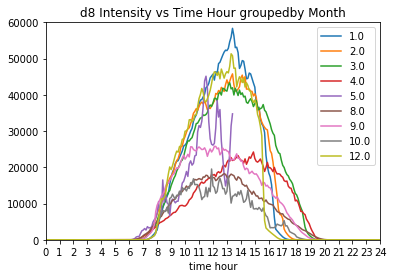

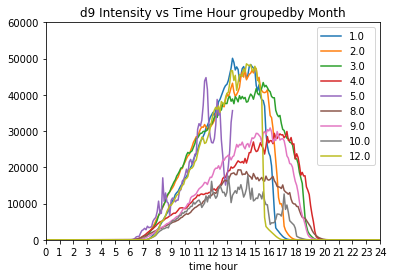

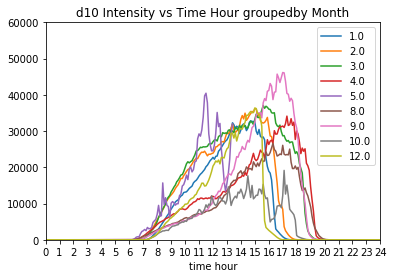

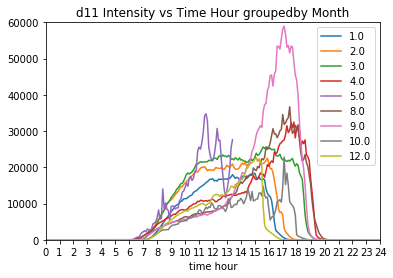

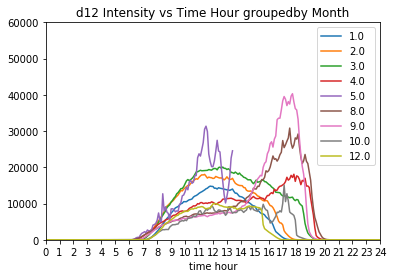

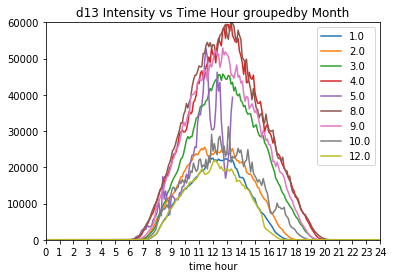

In [17]:
for i in timecolumns:
    df5.groupby('month')[i].plot(legend=True,title = i+' Intensity vs Time Hour groupedby Month', ylim =(0, 60000),xticks=range(0,25));
    plt.show()

## Plotting the Pearson Correlation of the original dataset

Plotting the Pearson's correlation of the original dataset, we see that d1 to d13 have a high positive correlation with one another. 

The features of extracted datetime are different glimpses of the time stamp. 

Because of the sinusoidal to linear relationship, time and intensities have low relationship when plotting the correlations.

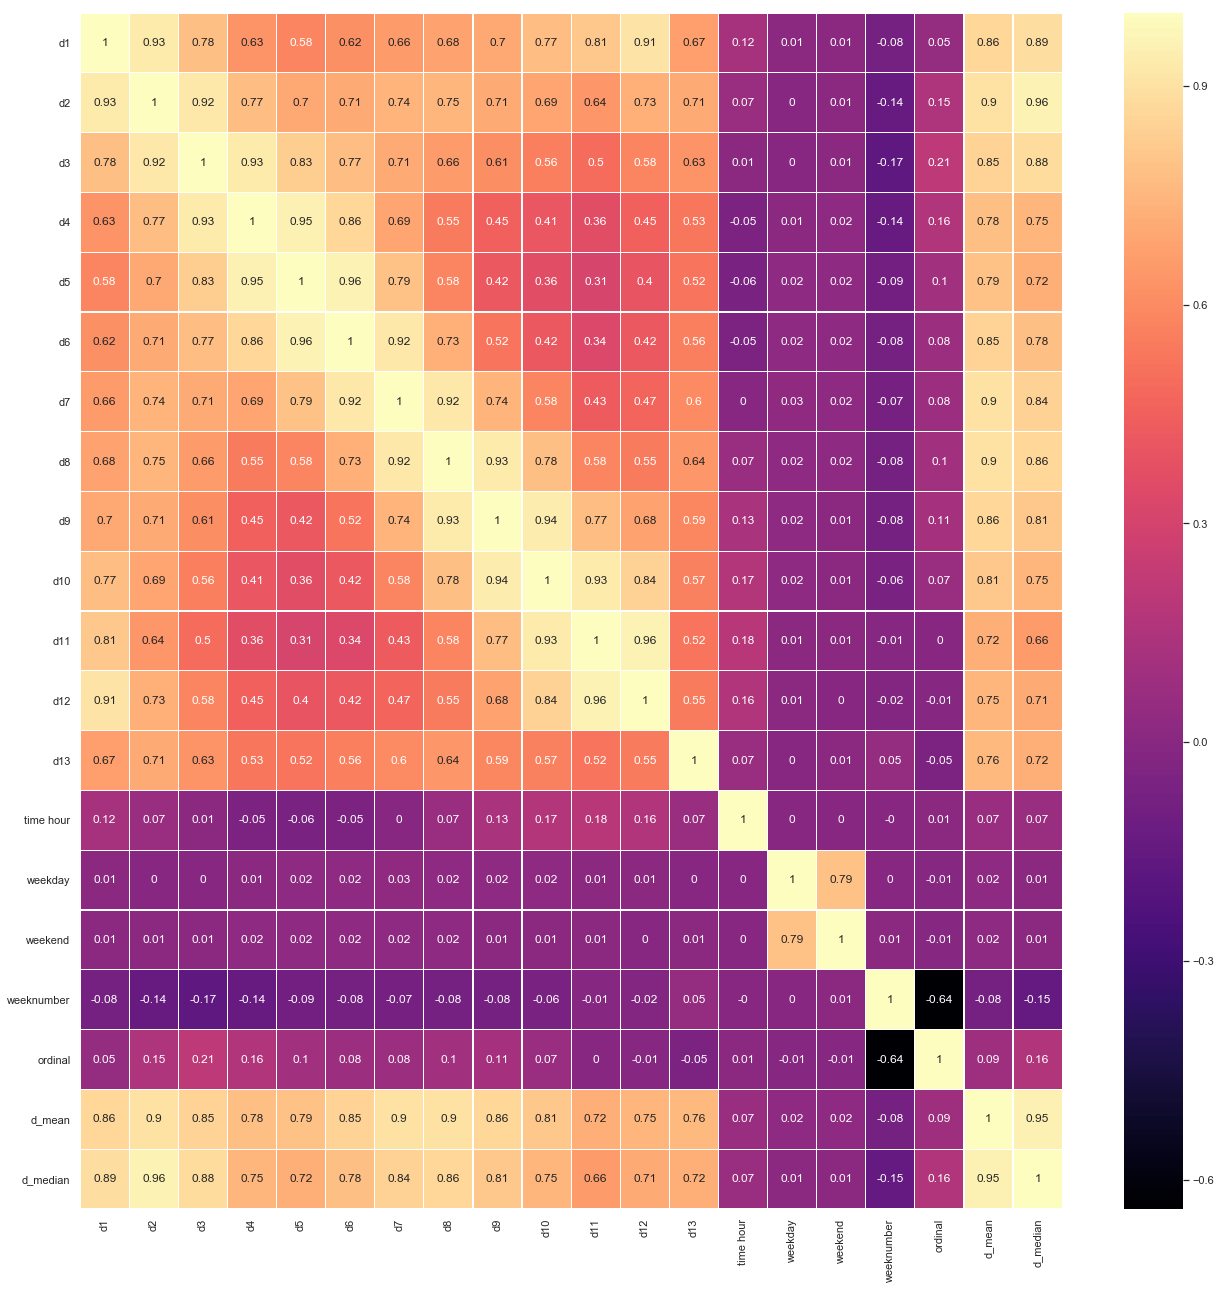

In [18]:
df = df.drop(columns= 'month')

sns.set(style="whitegrid") # one of the many styles to plot using
f, ax = plt.subplots(figsize=(22, 22))

hm = sns.heatmap(df.corr(method = 'pearson').round(2), annot = True, cmap = 'magma', linecolor ='white' , linewidth =0.2)

## Note: Subsetting for Time Complexity of Algorithms

Due to time and CPU restraints, the original dataset is randomized and subsetted for the same effect of clustering the whole dataset.

A lot of algorithms, including clustering and dimensionality reduction does not scale the more data there is. For the sake of time space complexity, the data is reduced because some algorithm have exponential or polynomial time.

In [19]:
data = df.values

np.random.shuffle(data)
train, test = np.split(data, [int(.9*len(data))])
trim_data = pd.DataFrame(test)

trim_data.columns = df.columns

## Dummy variables and log transformations

Due to the nature of the dataset, d1 to d13 are heavily right skewed because the half of the day has no intensity at all. Therefore, d1 and d13 are log transformed for a better distribution. In addition, dummy variables with a tolerance of 20 intensity self categorizes as "zeros" for when the intensity is negligible for night time.

Time hour and weekday distribution is even for the dataset while week of the year, month, and ordinal have sparsity because the dataset does not represent the full year.

The d1 to 13 intensities have a better distribution after log transformation. As expected, intensity is split evenly between day and night.

In [20]:
for column in d_columns:
    trim_data[str(column)+'_log'] = np.log(trim_data[column]+1)
    trim_data[str(column)+'_zeros'] = np.where(trim_data[column] < 20, 1, 0)

trim_data = trim_data.drop(columns=d_columns)

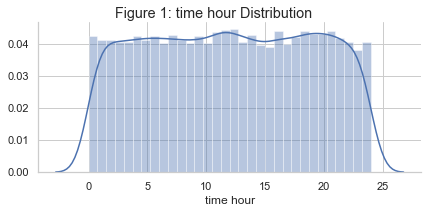

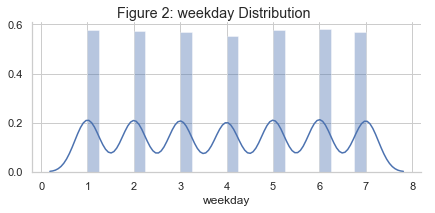

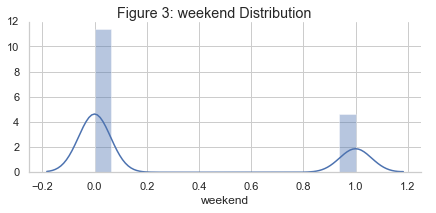

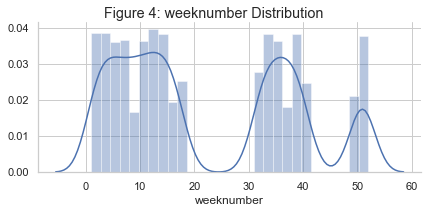

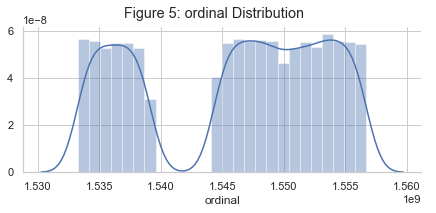

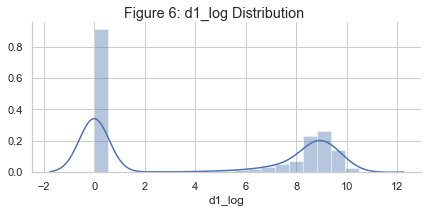

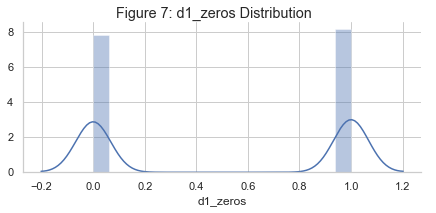

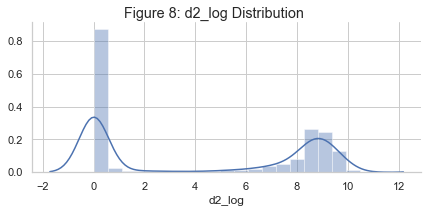

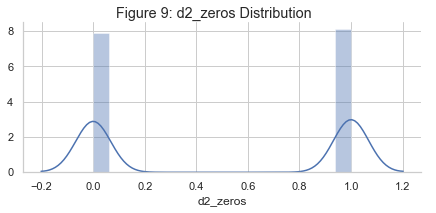

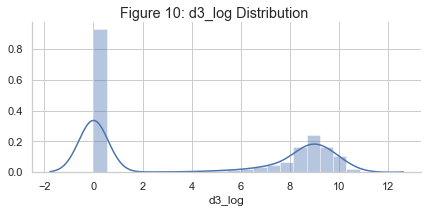

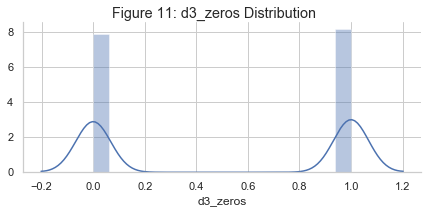

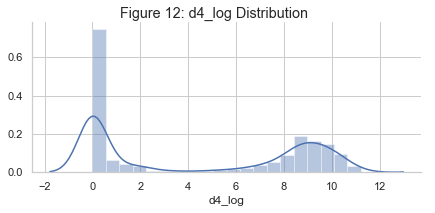

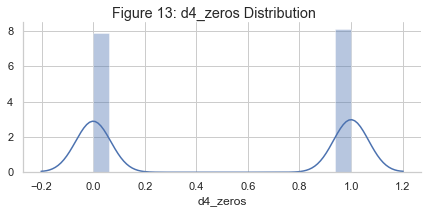

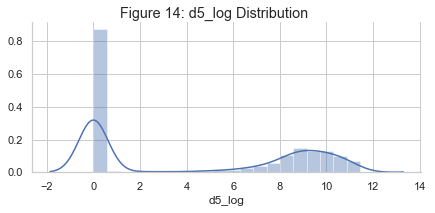

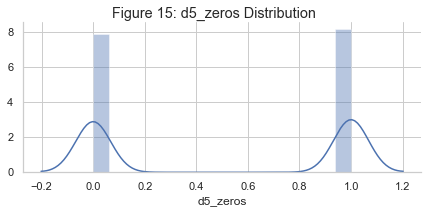

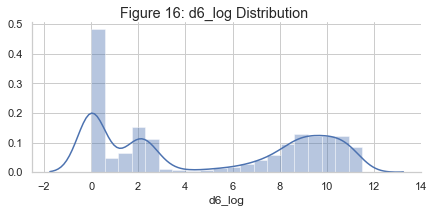

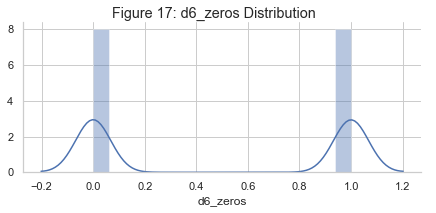

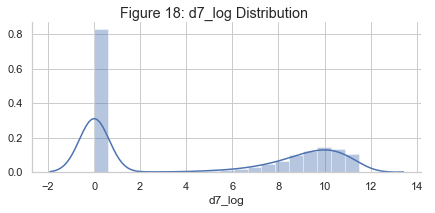

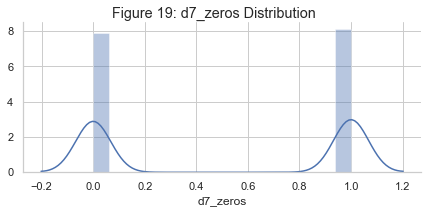

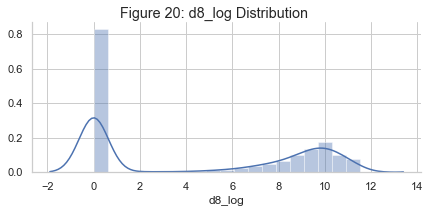

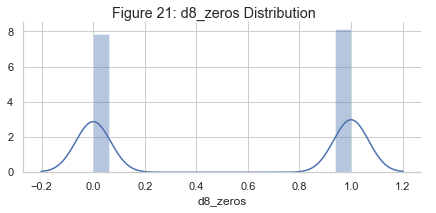

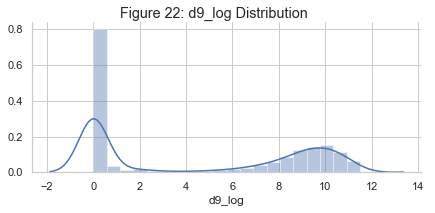

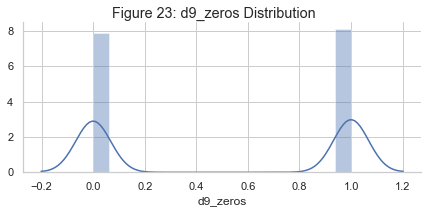

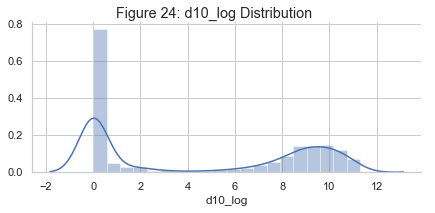

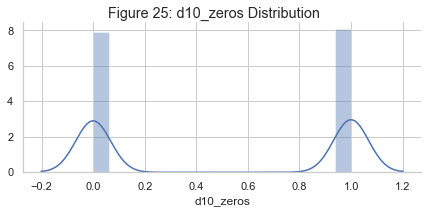

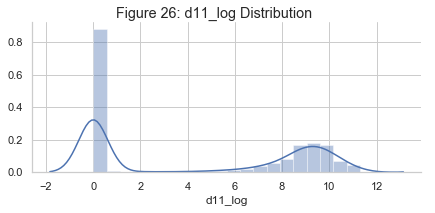

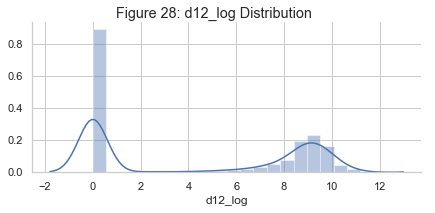

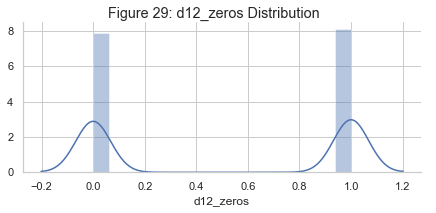

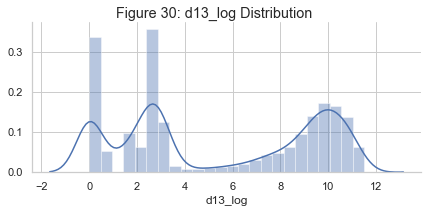

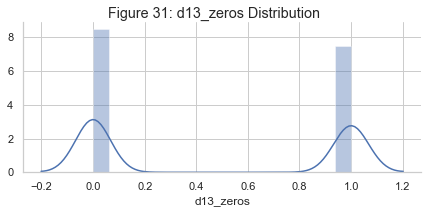

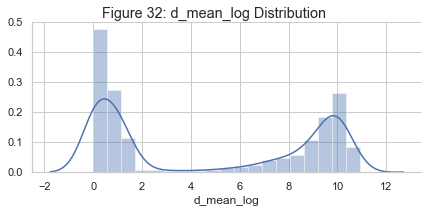

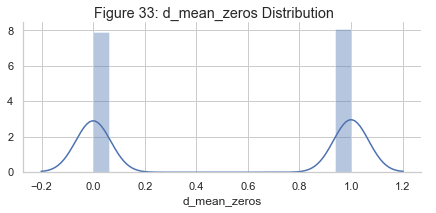

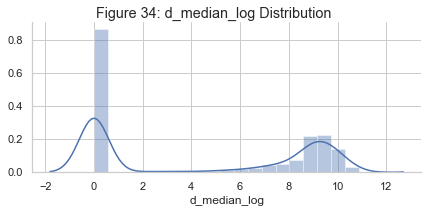

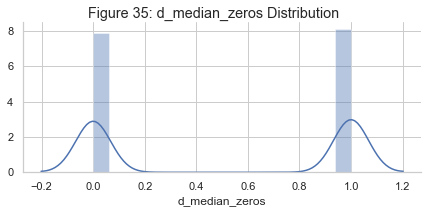

In [21]:
plt.rcParams['figure.max_open_warning']=40
colnames=list(trim_data.select_dtypes(exclude='O').columns.values)
for i in colnames[0:]:
    facet = sns.FacetGrid(trim_data,aspect=2)
    facet.map(sns.distplot,i)
    facet.add_legend()
    facet.fig.suptitle(''.join(map(str, list(["Figure ",colnames.index(i)+1,": ",i," Distribution"]))))
    plt.show()

## Plotting the Pearson Correlation of the new dataset

Plotting the Pearson's correlation of the d1 to d13 dataset after logging, we see that the correlations between intensities and dummy zeros are much higher towards 1 and -1, respectively. All the other correlations remain about the same as the dataset prior.

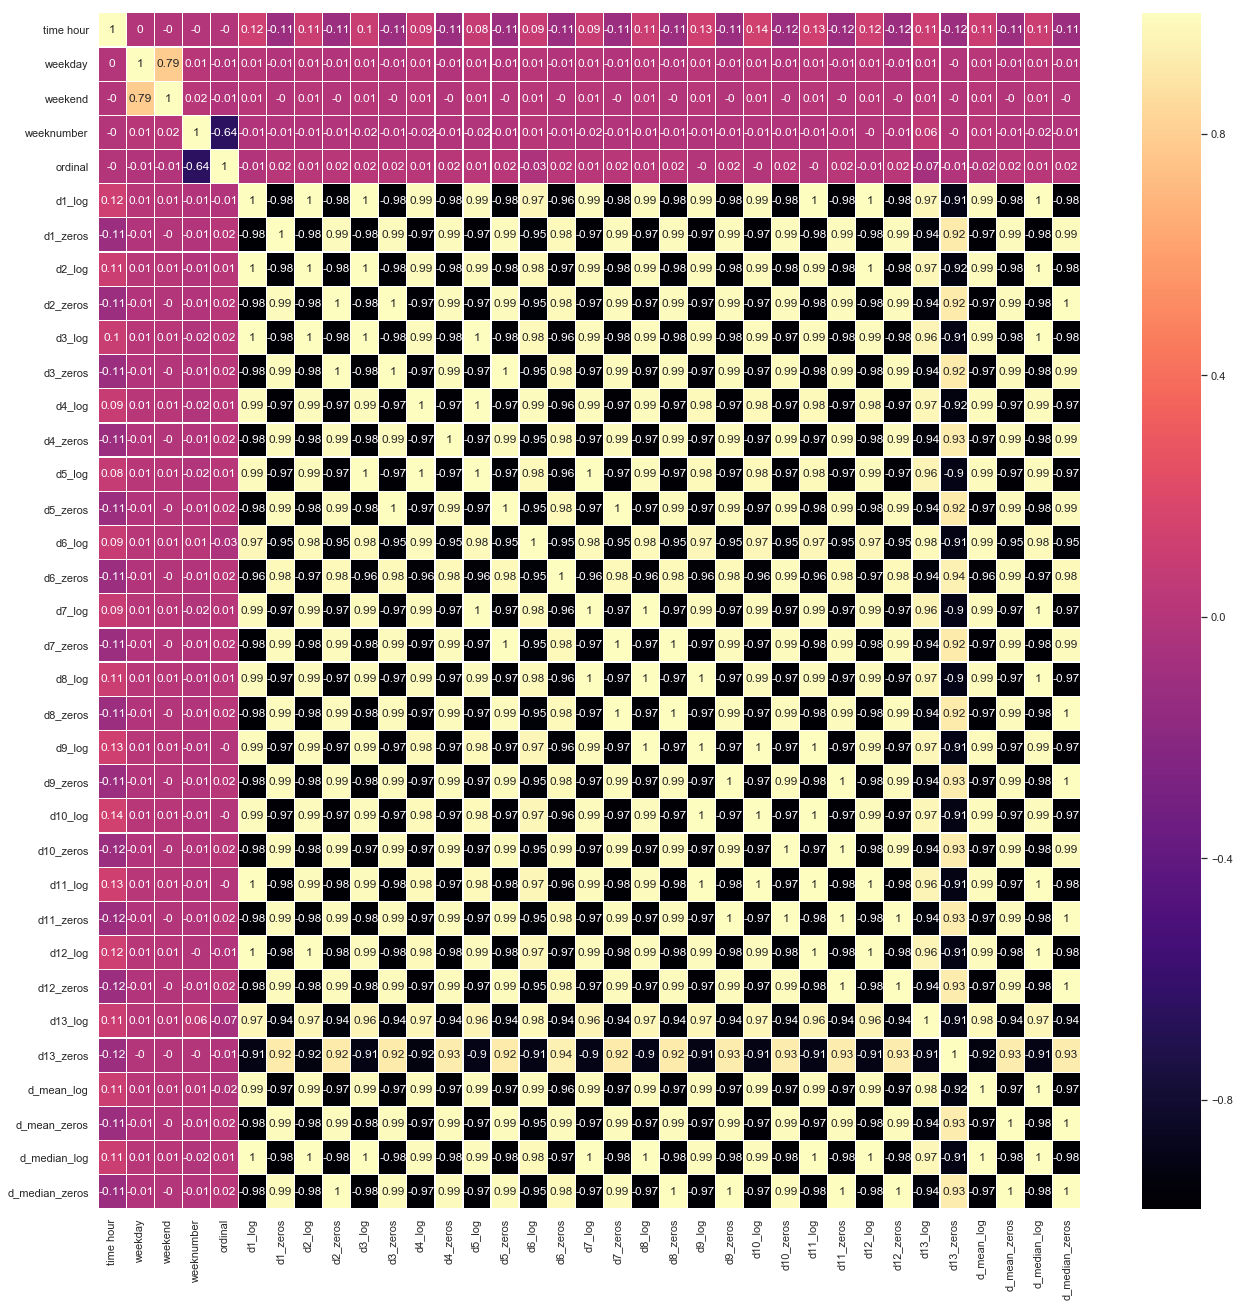

In [22]:
sns.set(style="whitegrid") # one of the many styles to plot using
f, ax = plt.subplots(figsize=(22, 22))

hm = sns.heatmap(trim_data[colnames].corr(method = 'pearson').round(2), annot = True, cmap = 'magma', linecolor ='white' , linewidth =0.2)

# Decomposing data to lower dimension for clustering

Visualizing high-dimensional data by projecting it into a low-dimensional space for easier visualization and grouping.

Here is a function that measures the silhouette score of cosine and euclidean distances, where the mean distance between a sample is compared to all other points in the same class and the mean distance between a sample and all other points in the next nearest cluster.

For Euclidean distance, a value of +1 indicates that the sample is far away from its neighboring cluster and very close to the cluster its assigned and value of -1 indicates that the point is close to its neighboring cluster than to the cluster its assigned. And, a value of 0 means its at the boundary of the distance between the two cluster. Value of +1 is ideal and -1 is least preferred. Hence, higher the value better is the cluster configuration.

To find the optimal number of clusters, find the highest silhouette score per given number of clusters interval.

In [23]:
def cluster_analysis(data,labels, per_cluster=True):
    metrics = ['cosine', 'euclidean']
    avg_metrics = {}
    data = pd.DataFrame(data)

    for metric in metrics:
        avg_metrics[metric] = silhouette_score(data, labels, metric=metric)
        data.loc[data.index, metric] = silhouette_samples(data, labels, metric=metric)

    avg_metrics = pd.DataFrame([avg_metrics], index = ['Average for all Clusters'])
    
    if per_cluster:
    
        per_cluster_metrics = pd.DataFrame()
        for cluster_id, group in data.groupby(labels):
            row = group[metrics].mean()
            row['cluster_id'] = int(cluster_id)
            per_cluster_metrics = per_cluster_metrics.append([row])
            gc.collect()

        per_cluster_metrics['cluster_id'] = per_cluster_metrics['cluster_id'].astype(int)
        per_cluster_metrics = per_cluster_metrics.set_index('cluster_id')
        ss_metrics = pd.DataFrame([(per_cluster_metrics ** 2).sum()], index = ['Sum of Squares for all Clusters'])
    else:
        per_cluster_metrics = None
        ss_metrics = None
    
    return avg_metrics, ss_metrics, per_cluster_metrics

# 1. PCA (Principal Component Analysis)

PCA creates low-dimensional embeddings that best preserves the overall variance of the dataset. In PCA, linear projection is used and its components can correlate with the original dataset using heatmap analysis.

The 2D PCA plot shows that the first component is a weak mixture of all the log transformed D1 to D13 variables and the second component is a direct representation of the ordinal datetime.

The 3D PCA plot shows the third component depth is a direct representation of time hour.

One drawback of PCA is that it is a linear projection, meaning it can’t capture non-linear dependencies. 

In [24]:
pca = PCA(n_components=3)

In [25]:
trim_data_pca = pca.fit_transform(trim_data.drop(columns='ordinal'))

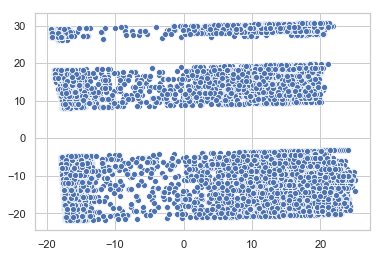

In [26]:
sns.scatterplot(trim_data_pca[:,0],trim_data_pca[:,1]);

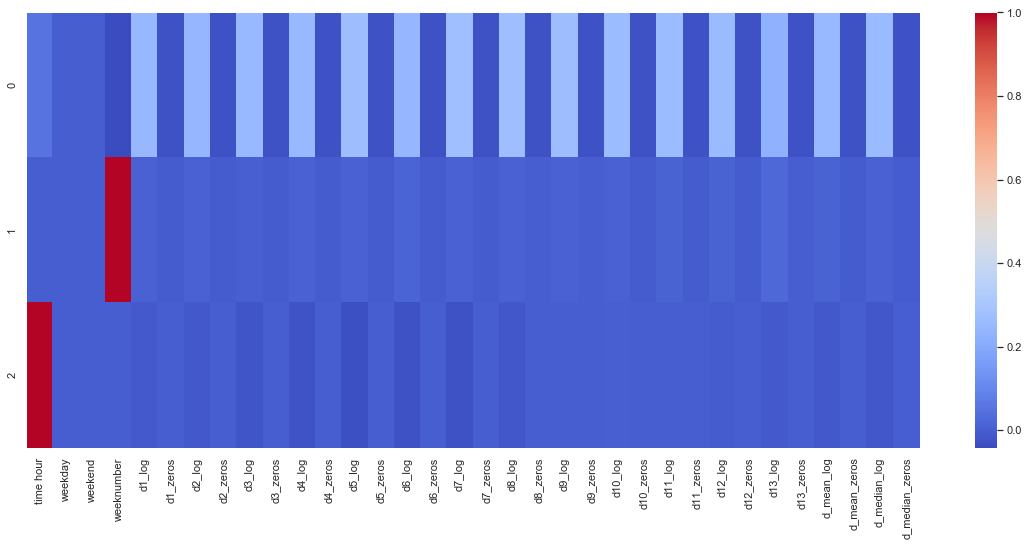

In [27]:
plt.figure(figsize=(20,8))
sns.heatmap(pd.DataFrame(pca.components_,columns=trim_data.drop(columns='ordinal').columns),cmap='coolwarm');

## Dataset Limitations

Unfortunately, there are "recording" gaps in the data, which exists because certain months out of the year does not exist, which leads to unusual segmenting of the data and creating unnatural clusters that would not have existed had there been a year's dataset. Therefore, 'week of year' as well as ordinal date time has to be removed to focus on "day-length patterns in the data."

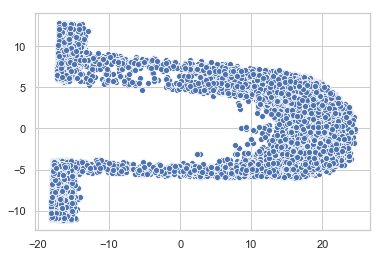

In [28]:
pca = PCA(n_components=3)
trim_data_pca = pca.fit_transform(trim_data.drop(columns=['ordinal','weeknumber']))
sns.scatterplot(trim_data_pca[:,0],trim_data_pca[:,1]);

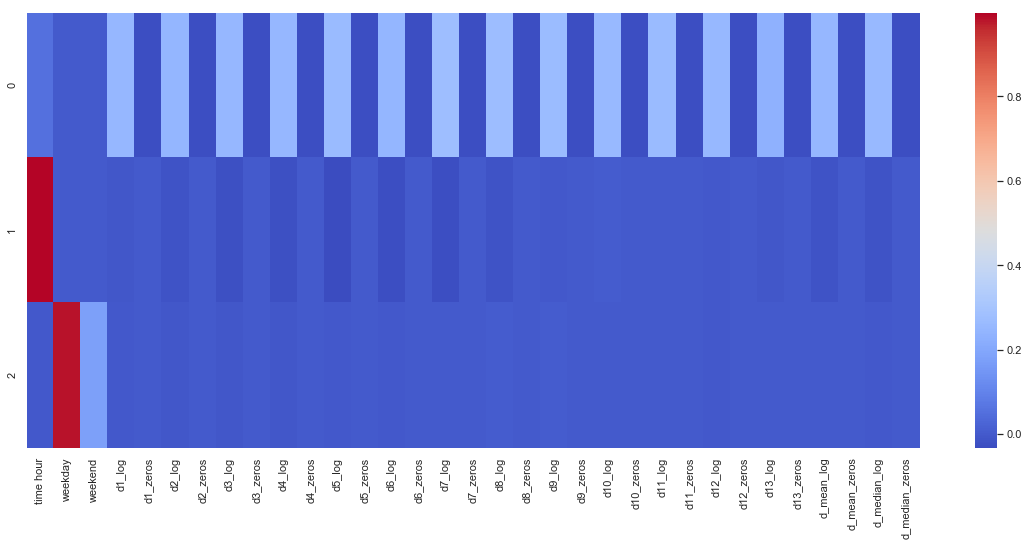

In [29]:
plt.figure(figsize=(20,8))
sns.heatmap(pd.DataFrame(pca.components_,columns=trim_data.drop(columns=['ordinal','weeknumber']).columns),cmap='coolwarm');

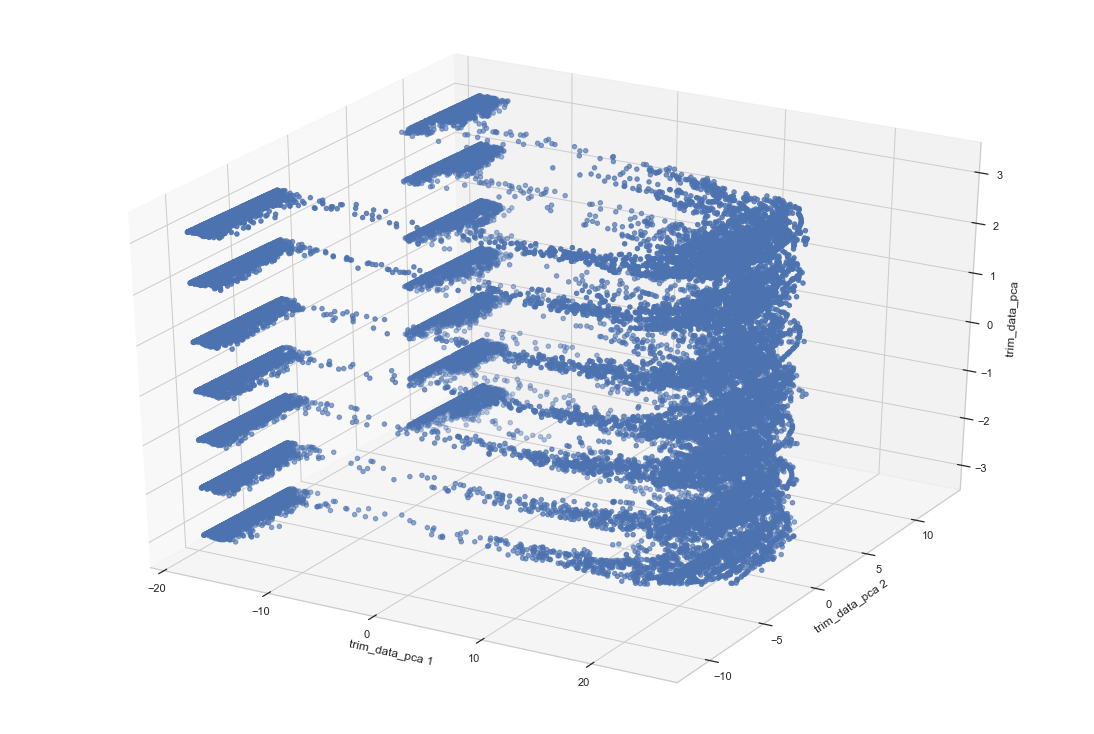

In [30]:
fig = pyplot.figure(figsize=(15, 10))
ax = Axes3D(fig)

ax.scatter(trim_data_pca[:,0],trim_data_pca[:,1],trim_data_pca[:,2])

ax.set_xlabel('trim_data_pca 1')
ax.set_ylabel('trim_data_pca 2')
ax.set_zlabel('trim_data_pca ')

pyplot.show()

# Clustering of data: PCA

Euclidean Distance measures how far apart two points in a n-dimensional space and Cosine Similarity measures the angle between two points at vertex zero.

The harmonic mean of euclidean and cosine Silhouette score is introduced to quantify optimal number of clusters because one would want to optimize for both instead of for one over another in the evaluation process. Given that both range from -1 to 1, it would be ideal to optimize for both.

# a) MiniBatchKMeans: PCA

Due to the nature of unsupervised clustering, there is no previous labels to compare to after the clusters are made. Therefore, to choose the optimal cluster, the highest Euclidean distance between clusters is chosen

In [31]:
best_MiniBatchKMeans_model = (None, None, -1.0)

n_clusters = np.arange(2, 11, 1)

models = []

for n in n_clusters:
    models.append((MiniBatchKMeans, {"n_clusters": n}))

for i, (Model, kwargs) in enumerate(models):
    print(Model.__name__, kwargs)
    silhouette = 0.0
    model = Model(**kwargs)
    model.fit(trim_data_pca)
    unique, counts = np.unique(model.labels_, return_counts=True)
    
    avg_metrics, _, _ = cluster_analysis(trim_data_pca,model.labels_, per_cluster=False)
    silhouette_euclidean = avg_metrics['euclidean'][0]
    silhouette_cosine = avg_metrics['cosine'][0]
    
    silhouette = (2 * silhouette_euclidean * silhouette_cosine) / (silhouette_euclidean + silhouette_cosine) # harmonic mean
    if best_MiniBatchKMeans_model[2] < silhouette:
        best_MiniBatchKMeans_model = (model, kwargs, silhouette)
    print("Silhouette harmonic mean of euclidean and cosine: ", silhouette)

MiniBatchKMeans {'n_clusters': 2}
Silhouette harmonic mean of euclidean and cosine:  0.8061102590272036
MiniBatchKMeans {'n_clusters': 3}
Silhouette harmonic mean of euclidean and cosine:  0.8429146999007516
MiniBatchKMeans {'n_clusters': 4}
Silhouette harmonic mean of euclidean and cosine:  0.6895210774949294
MiniBatchKMeans {'n_clusters': 5}
Silhouette harmonic mean of euclidean and cosine:  0.604697248424382
MiniBatchKMeans {'n_clusters': 6}
Silhouette harmonic mean of euclidean and cosine:  0.6232338494441333
MiniBatchKMeans {'n_clusters': 7}
Silhouette harmonic mean of euclidean and cosine:  0.4535586865888705
MiniBatchKMeans {'n_clusters': 8}
Silhouette harmonic mean of euclidean and cosine:  0.41501385909854266
MiniBatchKMeans {'n_clusters': 9}
Silhouette harmonic mean of euclidean and cosine:  0.49632909060053426
MiniBatchKMeans {'n_clusters': 10}
Silhouette harmonic mean of euclidean and cosine:  0.3416755238314215


In [32]:
print("The best results were with the MiniBatchKMeans model: ", best_MiniBatchKMeans_model[1])
print("The results obtained: ")
print("Silhouette harmonic mean of euclidean and cosine: ", best_MiniBatchKMeans_model[2])

The best results were with the MiniBatchKMeans model:  {'n_clusters': 3}
The results obtained: 
Silhouette harmonic mean of euclidean and cosine:  0.8429146999007516


In [33]:
n_clusters=best_MiniBatchKMeans_model[1]['n_clusters']
cls = MiniBatchKMeans(n_clusters=n_clusters, random_state=0)
cls.fit(trim_data_pca)
labels = cls.labels_
centroids = cls.cluster_centers_
avg_metrics, ss_metrics, per_cluster_metrics = cluster_analysis(trim_data_pca,labels)

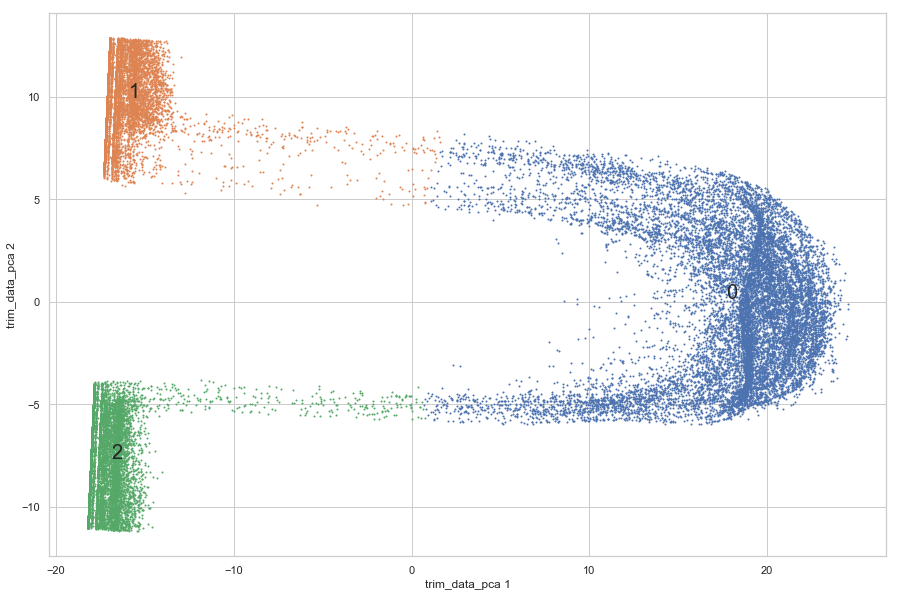

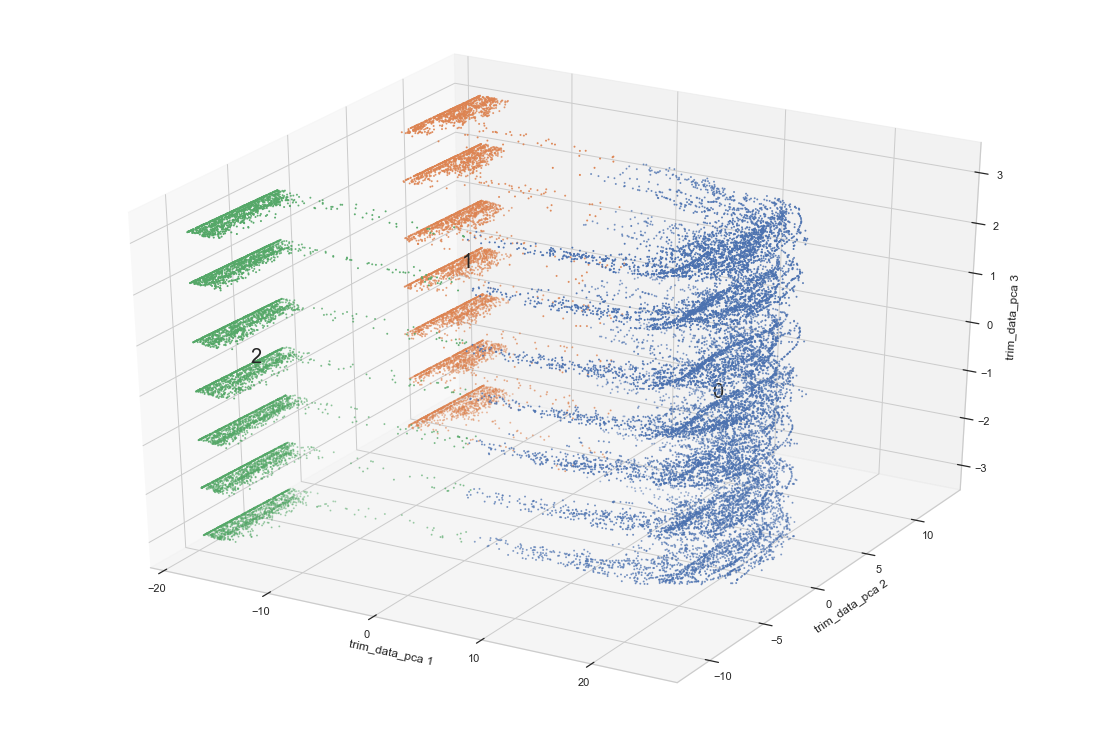

cosine  euclidean
Average for all Clusters  0.937774   0.765362

cosine  euclidean
cluster_id                     
0           0.937535   0.768908
1           0.937115   0.762620
2           0.938700   0.761566

cosine  euclidean
Sum of Squares for all Clusters  2.638313   1.752791

In [34]:
plt.figure(figsize=(15, 10))

for cluster_id in np.unique(labels):
    d = np.where(cluster_id == labels)
    label = 'Cluster #' + str(cluster_id)
    plt.scatter(trim_data_pca[:,0][d], trim_data_pca[:,1][d], label=label, s=1)
for i in range(n_clusters):
    plt.text(centroids[:, 0][i], centroids[:, 1][i], i, fontsize=20)

plt.xlabel("trim_data_pca 1")
plt.ylabel("trim_data_pca 2")    
plt.show()

fig = pyplot.figure(figsize=(15, 10))
ax = Axes3D(fig)

for cluster_id in np.unique(labels):
    d = np.where(cluster_id == labels)
    label = 'Cluster #' + str(cluster_id)
    ax.scatter(trim_data_pca[:,0][d], trim_data_pca[:,1][d],trim_data_pca[:,2][d], label=label, s=1)
for i in range(n_clusters):
    ax.text(centroids[:, 0][i], centroids[:, 1][i],centroids[:, 2][i], i, fontsize=20)

ax.set_xlabel('trim_data_pca 1')
ax.set_ylabel('trim_data_pca 2')
ax.set_zlabel('trim_data_pca 3')

pyplot.show()

display(avg_metrics)
display(per_cluster_metrics)
display(ss_metrics)

# b) AgglomerativeClustering: PCA

In [35]:
best_agglomerative_model = (None, None, -1.0)

n_clusters = np.arange(2, 11, 1)

models = []

for n in n_clusters:
    models.append((AgglomerativeClustering, {"n_clusters": n}))

for i, (Model, kwargs) in enumerate(models):
    print(Model.__name__, kwargs)
    silhouette = 0.0
    model = Model(**kwargs)
    model.fit(trim_data_pca)
    unique, counts = np.unique(model.labels_, return_counts=True)

    avg_metrics, _, _ = cluster_analysis(trim_data_pca,model.labels_, per_cluster=False)
    silhouette_euclidean = avg_metrics['euclidean'][0]
    silhouette_cosine = avg_metrics['cosine'][0]
    
    silhouette = (2 * silhouette_euclidean * silhouette_cosine) / (silhouette_euclidean + silhouette_cosine) # harmonic mean
    if best_agglomerative_model[2] < silhouette:
        best_agglomerative_model = (model, kwargs, silhouette)
        n_clusters = silhouette
    print("Silhouette harmonic mean of euclidean and cosine: ", silhouette)

AgglomerativeClustering {'n_clusters': 2}
Silhouette harmonic mean of euclidean and cosine:  0.7962411572347365
AgglomerativeClustering {'n_clusters': 3}
Silhouette harmonic mean of euclidean and cosine:  0.8346376240964537
AgglomerativeClustering {'n_clusters': 4}
Silhouette harmonic mean of euclidean and cosine:  0.679604068535852
AgglomerativeClustering {'n_clusters': 5}
Silhouette harmonic mean of euclidean and cosine:  0.6878591756325088
AgglomerativeClustering {'n_clusters': 6}
Silhouette harmonic mean of euclidean and cosine:  0.578194563688911
AgglomerativeClustering {'n_clusters': 7}
Silhouette harmonic mean of euclidean and cosine:  0.5819062413071009
AgglomerativeClustering {'n_clusters': 8}
Silhouette harmonic mean of euclidean and cosine:  0.44435328704996496
AgglomerativeClustering {'n_clusters': 9}
Silhouette harmonic mean of euclidean and cosine:  0.43437328361966787
AgglomerativeClustering {'n_clusters': 10}
Silhouette harmonic mean of euclidean and cosine:  0.40090173

In [36]:
print("The best results were with the Agglomerative model: ", best_agglomerative_model[1])
print("The results obtained: ")
print("Silhouette harmonic mean of euclidean and cosine: ", best_agglomerative_model[2])

The best results were with the Agglomerative model:  {'n_clusters': 3}
The results obtained: 
Silhouette harmonic mean of euclidean and cosine:  0.8346376240964537


In [37]:
n_clusters=best_agglomerative_model[1]['n_clusters']
cls = AgglomerativeClustering(n_clusters=n_clusters)
cls.fit(trim_data_pca)
labels = cls.labels_
# centroids = cls.cluster_centers_
avg_metrics, ss_metrics, per_cluster_metrics = cluster_analysis(trim_data_pca,labels)

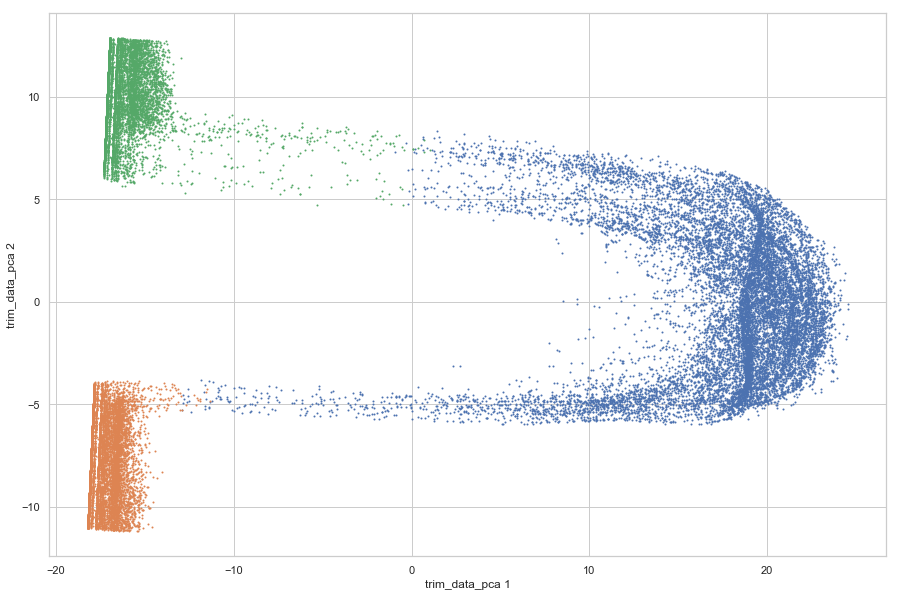

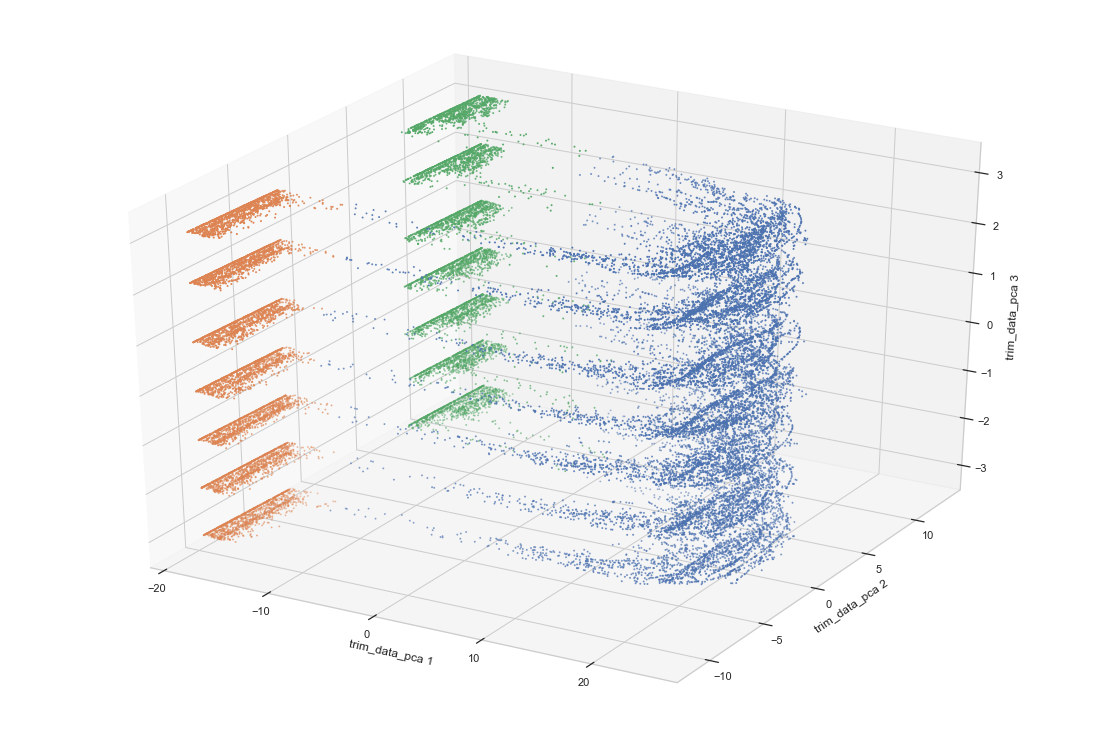

cosine  euclidean
Average for all Clusters  0.92369   0.761246

cosine  euclidean
cluster_id                     
0           0.897265   0.744396
1           0.952755   0.784080
2           0.945088   0.769558

cosine  euclidean
Sum of Squares for all Clusters  2.606017   1.761127

In [38]:
plt.figure(figsize=(15, 10))

for cluster_id in np.unique(labels):
    d = np.where(cluster_id == labels)
    label = 'Cluster #' + str(cluster_id)
    plt.scatter(trim_data_pca[:,0][d], trim_data_pca[:,1][d], label=label, s=1)
    
    
# for i in range(n_clusters):
#     plt.text(centroids[:, 0][i], centroids[:, 1][i], i, fontsize=20)
plt.xlabel("trim_data_pca 1")
plt.ylabel("trim_data_pca 2")
plt.show()

fig = pyplot.figure(figsize=(15, 10))
ax = Axes3D(fig)

for cluster_id in np.unique(labels):
    d = np.where(cluster_id == labels)
    label = 'Cluster #' + str(cluster_id)
    ax.scatter(trim_data_pca[:,0][d], trim_data_pca[:,1][d],trim_data_pca[:,2][d], label=label, s=1)
# for i in range(n_clusters):
#     ax.text(centroids[:, 0][i], centroids[:, 1][i],centroids[:, 2][i], i, fontsize=20)

ax.set_xlabel('trim_data_pca 1')
ax.set_ylabel('trim_data_pca 2')
ax.set_zlabel('trim_data_pca 3')

pyplot.show()

display(avg_metrics)
display(per_cluster_metrics)
display(ss_metrics)

# c) DBSCAN: PCA

In [39]:
best_dbscan_model = (None, None, -1.0)

eps = np.arange(1, 2.1, 0.1)

models = []

for eps_val in eps:
    models.append((DBSCAN, {"eps": eps_val, "min_samples": 30}))

for i, (Model, kwargs) in enumerate(models):
    silhouette = 0.0
    model = Model(**kwargs)
    model.fit(trim_data_pca)
    unique, counts = np.unique(model.labels_, return_counts=True)
    if len(dict(zip(unique, counts))) > 1:

        avg_metrics, _, _ = cluster_analysis(trim_data_pca,model.labels_, per_cluster=False)
        silhouette_euclidean = avg_metrics['euclidean'][0]
        silhouette_cosine = avg_metrics['cosine'][0]
        
        silhouette = (2 * silhouette_euclidean * silhouette_cosine) / (silhouette_euclidean + silhouette_cosine) # harmonic mean
        if best_dbscan_model[2] < silhouette:
            best_dbscan_model = (model, kwargs, silhouette)
    print(Model.__name__, kwargs)
    print("Silhouette harmonic mean of euclidean and cosine: ", silhouette)

DBSCAN {'eps': 1.0, 'min_samples': 30}
Silhouette harmonic mean of euclidean and cosine:  0.18038320142350406
DBSCAN {'eps': 1.1, 'min_samples': 30}
Silhouette harmonic mean of euclidean and cosine:  0.15078164617241774
DBSCAN {'eps': 1.2000000000000002, 'min_samples': 30}
Silhouette harmonic mean of euclidean and cosine:  0.6397286558808196
DBSCAN {'eps': 1.3000000000000003, 'min_samples': 30}
Silhouette harmonic mean of euclidean and cosine:  0.6516722804535586
DBSCAN {'eps': 1.4000000000000004, 'min_samples': 30}
Silhouette harmonic mean of euclidean and cosine:  0.7914159048276576
DBSCAN {'eps': 1.5000000000000004, 'min_samples': 30}
Silhouette harmonic mean of euclidean and cosine:  0.7344265138061199
DBSCAN {'eps': 1.6000000000000005, 'min_samples': 30}
Silhouette harmonic mean of euclidean and cosine:  0.7943192978195541
DBSCAN {'eps': 1.7000000000000006, 'min_samples': 30}
Silhouette harmonic mean of euclidean and cosine:  0.7950632376510064
DBSCAN {'eps': 1.8000000000000007, '

In [40]:
print("The best results were with the DBSCAN model: ", best_dbscan_model[1])
print("The results obtained: ")
print("Silhouette harmonic mean of euclidean and cosine: ", best_dbscan_model[2])

The best results were with the DBSCAN model:  {'eps': 1.7000000000000006, 'min_samples': 30}
The results obtained: 
Silhouette harmonic mean of euclidean and cosine:  0.7950632376510064


In [41]:
eps=best_dbscan_model[1]['eps']
min_samples=best_dbscan_model[1]['min_samples']

cls = DBSCAN(eps=eps, min_samples=min_samples)
cls.fit(trim_data_pca)
labels = cls.labels_
# centroids = cls.cluster_centers_
avg_metrics, ss_metrics, per_cluster_metrics = cluster_analysis(trim_data_pca,labels)

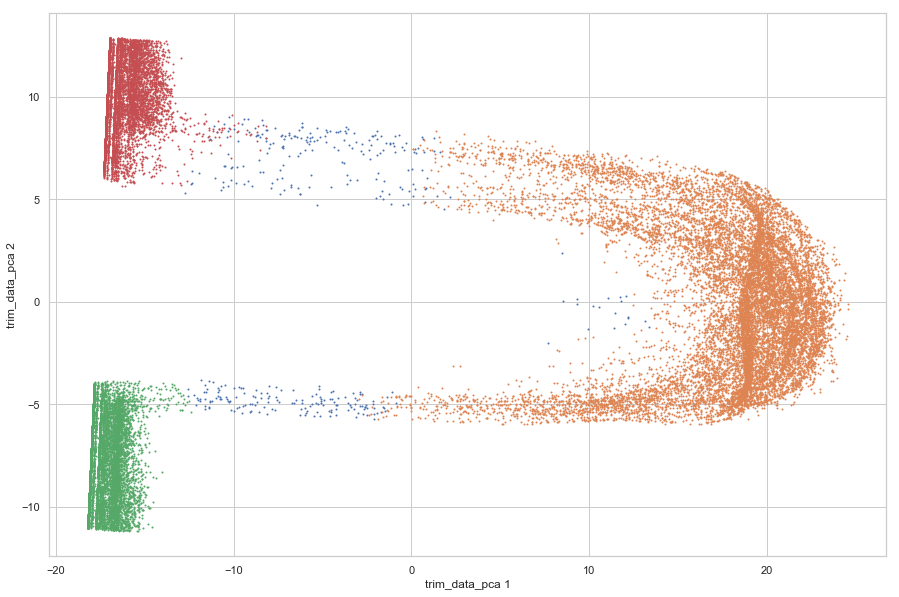

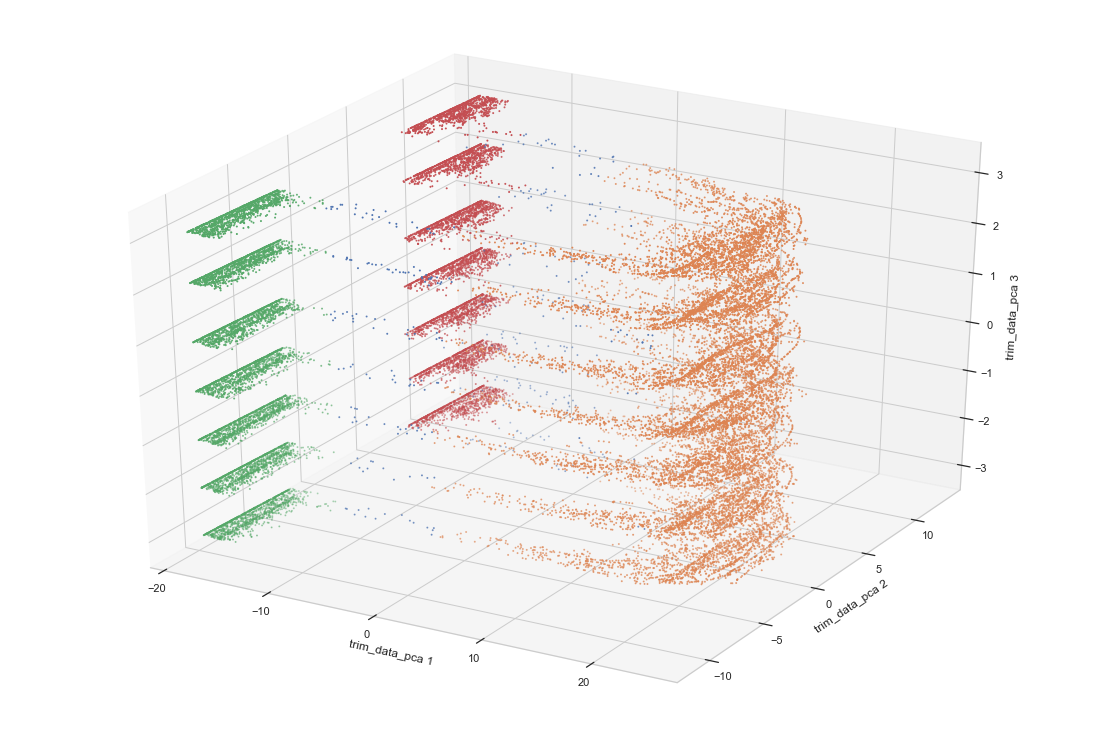

cosine  euclidean
Average for all Clusters  0.915988   0.702343

cosine  euclidean
cluster_id                     
-1         -0.805170   0.090178
 0          0.921500   0.656011
 1          0.951795   0.767561
 2          0.955240   0.755845

cosine  euclidean
Sum of Squares for all Clusters  3.315858   1.598935

In [42]:
plt.figure(figsize=(15, 10))

for cluster_id in np.unique(labels):
    d = np.where(cluster_id == labels)
    label = 'Cluster #' + str(cluster_id)
    plt.scatter(trim_data_pca[:,0][d], trim_data_pca[:,1][d], label=label, s=1)
    
plt.xlabel("trim_data_pca 1")
plt.ylabel("trim_data_pca 2")
# for i in range(n_clusters):
#     plt.text(centroids[:, 0][i], centroids[:, 1][i], i, fontsize=20)
plt.show()

fig = pyplot.figure(figsize=(15, 10))
ax = Axes3D(fig)

for cluster_id in np.unique(labels):
    d = np.where(cluster_id == labels)
    label = 'Cluster #' + str(cluster_id)
    ax.scatter(trim_data_pca[:,0][d], trim_data_pca[:,1][d],trim_data_pca[:,2][d], label=label, s=1)
# for i in range(n_clusters):
#     ax.text(centroids[:, 0][i], centroids[:, 1][i],centroids[:, 2][i], i, fontsize=20)

ax.set_xlabel('trim_data_pca 1')
ax.set_ylabel('trim_data_pca 2')
ax.set_zlabel('trim_data_pca 3')

pyplot.show()

display(avg_metrics)
display(per_cluster_metrics)
display(ss_metrics)

# d) Hierarchical Clustering: PCA

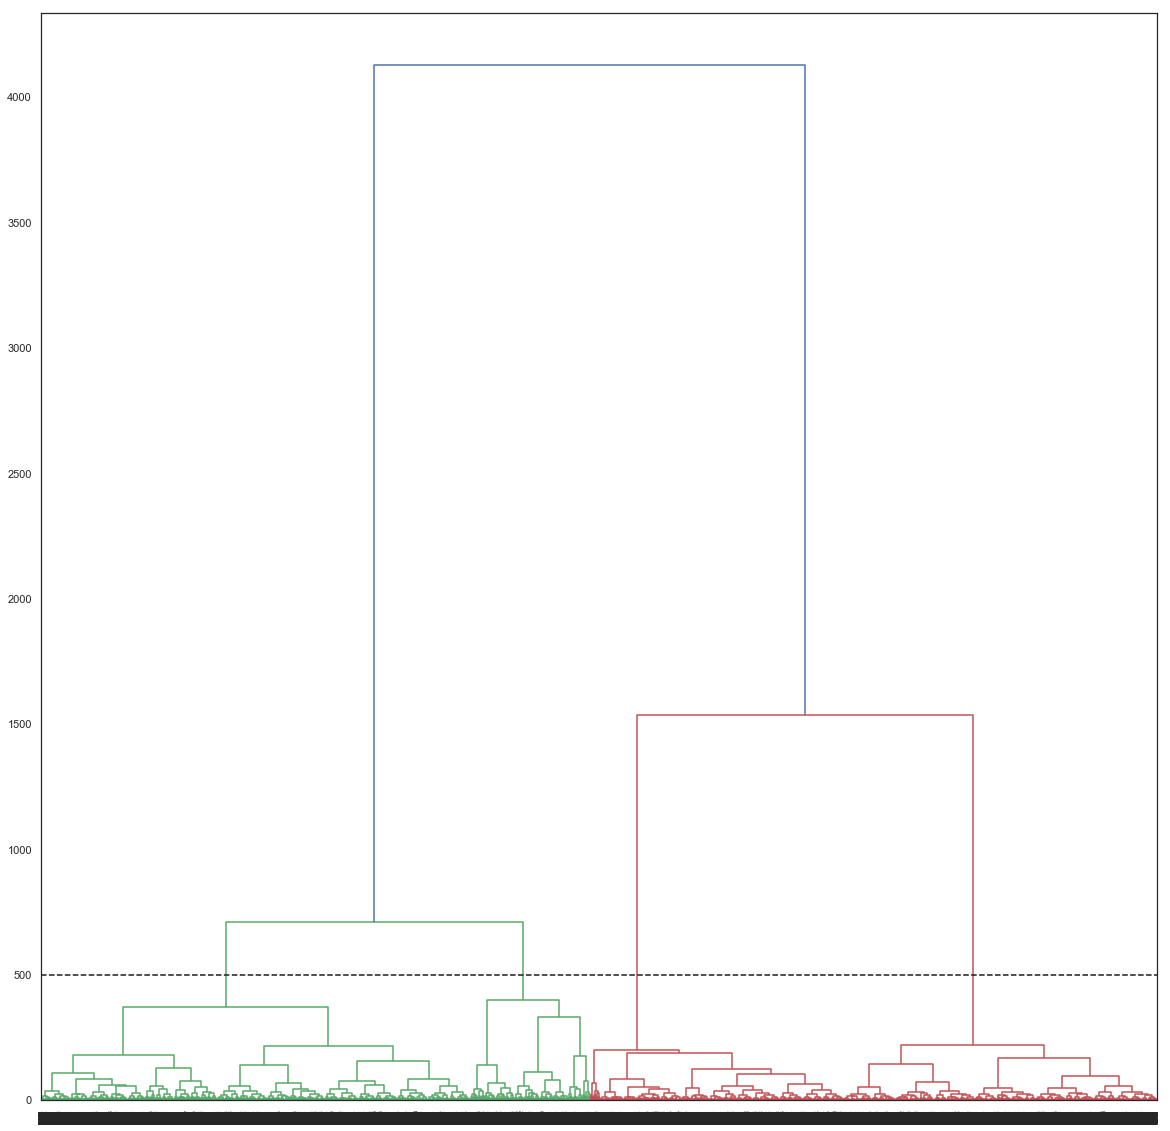

In [43]:
link = ward(trim_data_pca)
sns.set(style='white')
plt.figure(figsize=(20,20))
dendrogram(link)
ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [500,500],'--', c='k')
plt.show()

# 1. PCA Results:

After the number of clusters per algorithm was chosen by highest harmonic mean of euclidean and cosine silhouette score, the models are then compared to one another by the highest harmonic mean of euclidean and cosine silhouette score. 

Depending on the run, MiniBatchKMeans yielded the highest silhouette score of 0.937774 cosine similarity and 0.765362 euclidean distance at 3 clusters. The 3 clusters depict midnight to sunrise, mid-day hours, and sunset to sunrise. Had the dataset followed a 'time hour' that started at sun rise at 6:30 AM instead of 12:00 AM, the clustering would have been different in perhaps further distinguishing the time series clustering classification. 

For this run, Agglomerative clustering came in second with a silhouette score of 0.92369 cosine similarity and 0.761246 euclidean distance at 3 clusters.

DBSCAN clustering had a silhouette score of 0.915988 cosine similarity and 0.702343 euclidean distance at 4 clusters. The 4 clusters depict sunrise sunset, noon, and nights before and after.

Hierarchical clustering also suggests 4 clusters at 500, although it is quantitatively not applicable to assess.

# 2. t-SNE (T-distributed Stochastic Neighbor Embedding)

t-SNE uses stochastic neighbors, which means that there is no clear line between which points are neighbors of the other points. This lack of clear borders can be a major advantage because it allows t-SNE to naturally take both global and local structure into account. Local structure is more important than global structure, but points that are far away are not completely ignored, allowing for a 'well-balanced' dimensionality reduction.

Due to the non-linearity of the t-SNE, the components cannot be compared back to its original dataset

The benefit of t-SNE is that can handle the crowding problem very well with higher dimensionality reduction. The separation is better using t-SNE as it accounts for non-linear relationships as well.

In [44]:
gc.collect()
tsne = TSNE(n_components=3)

In [45]:
trim_data_tsne = tsne.fit_transform(trim_data)

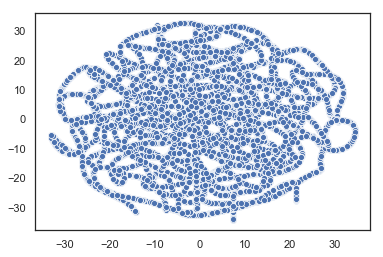

In [46]:
sns.scatterplot(trim_data_tsne[:,0],trim_data_tsne[:,1]);

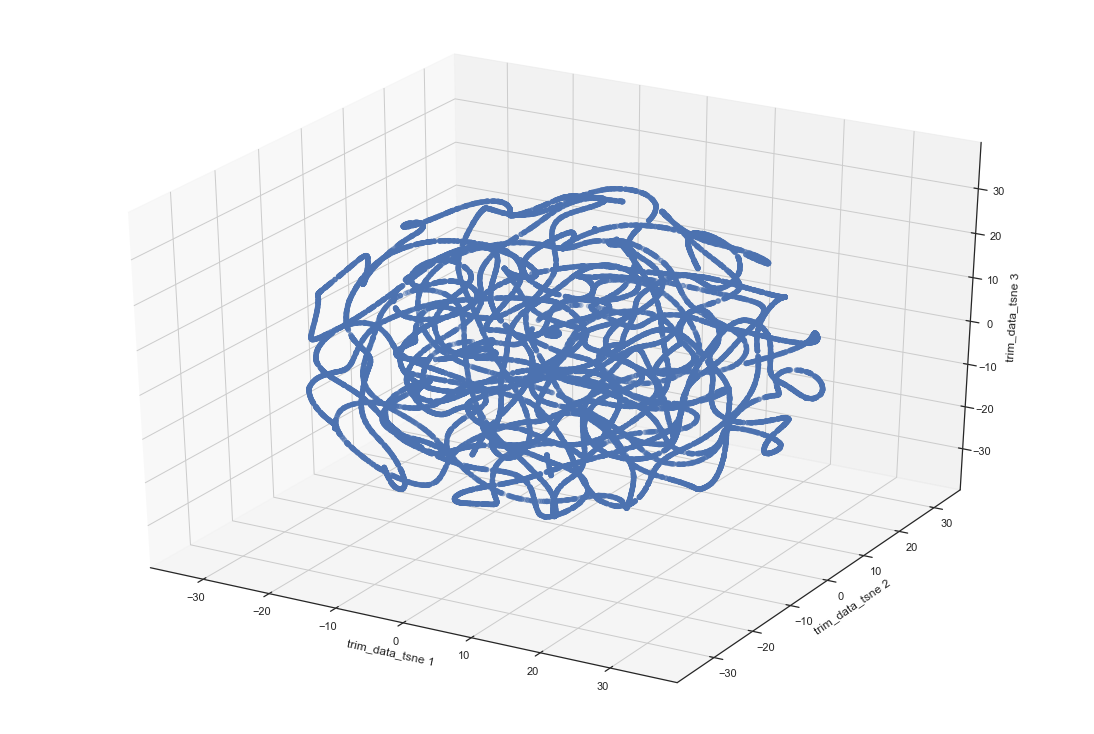

In [47]:
fig = pyplot.figure(figsize=(15, 10))
ax = Axes3D(fig)

ax.scatter(trim_data_tsne[:,0],trim_data_tsne[:,1],trim_data_tsne[:,2])

ax.set_xlabel('trim_data_tsne 1')
ax.set_ylabel('trim_data_tsne 2')
ax.set_zlabel('trim_data_tsne 3')

pyplot.show()

# Clustering of data

Euclidean Distance measures how far apart two points in a n-dimensional space and Cosine Similarity measures the angle between two points at vertex zero.

The harmonic mean of euclidean and cosine Silhouette score is introduced to quantify optimal number of clusters because one would want to optimize for both instead of for one over another in the evaluation process. Given that both range from -1 to 1, it would be ideal to optimize for both. 

# a) MiniBatchKMeans: TSNE

Due to the nature of unsupervised clustering, there is no previous labels to compare to after the clusters are made. Therefore, to choose the optimal cluster, the elbow of the 

In [48]:
best_MiniBatchKMeans_model = (None, None, -1.0)

n_clusters = np.arange(2, 11, 1)

models = []

for n in n_clusters:
    models.append((MiniBatchKMeans, {"n_clusters": n}))

for i, (Model, kwargs) in enumerate(models):
    print(Model.__name__, kwargs)
    silhouette = 0.0
    model = Model(**kwargs)
    model.fit(trim_data_tsne)
    unique, counts = np.unique(model.labels_, return_counts=True)
    
    avg_metrics, _, _ = cluster_analysis(trim_data_tsne,model.labels_, per_cluster=False)
    silhouette_euclidean = avg_metrics['euclidean'][0]
    silhouette_cosine = avg_metrics['cosine'][0]
    
    silhouette = (2 * silhouette_euclidean * silhouette_cosine) / (silhouette_euclidean + silhouette_cosine) # harmonic mean
    if best_MiniBatchKMeans_model[2] < silhouette:
        best_MiniBatchKMeans_model = (model, kwargs, silhouette)
    print("Silhouette harmonic mean of euclidean and cosine: ", silhouette)

MiniBatchKMeans {'n_clusters': 2}
Silhouette harmonic mean of euclidean and cosine:  0.2843332323108483
MiniBatchKMeans {'n_clusters': 3}
Silhouette harmonic mean of euclidean and cosine:  0.28751465110957464
MiniBatchKMeans {'n_clusters': 4}
Silhouette harmonic mean of euclidean and cosine:  0.3124298961487632
MiniBatchKMeans {'n_clusters': 5}
Silhouette harmonic mean of euclidean and cosine:  0.3008909876825393
MiniBatchKMeans {'n_clusters': 6}
Silhouette harmonic mean of euclidean and cosine:  0.31186333141166744
MiniBatchKMeans {'n_clusters': 7}
Silhouette harmonic mean of euclidean and cosine:  0.306034565241856
MiniBatchKMeans {'n_clusters': 8}
Silhouette harmonic mean of euclidean and cosine:  0.3027289739385388
MiniBatchKMeans {'n_clusters': 9}
Silhouette harmonic mean of euclidean and cosine:  0.3044289900917646
MiniBatchKMeans {'n_clusters': 10}
Silhouette harmonic mean of euclidean and cosine:  0.2914955928755932


In [49]:
print("The best results were with the MiniBatchKMeans model: ", best_MiniBatchKMeans_model[1])
print("The results obtained: ")
print("Silhouette harmonic mean of euclidean and cosine: ", best_MiniBatchKMeans_model[2])

The best results were with the MiniBatchKMeans model:  {'n_clusters': 4}
The results obtained: 
Silhouette harmonic mean of euclidean and cosine:  0.3124298961487632


In [50]:
n_clusters=best_MiniBatchKMeans_model[1]['n_clusters']
cls = MiniBatchKMeans(n_clusters=n_clusters, random_state=0)
cls.fit(trim_data_tsne)
labels = cls.labels_
centroids = cls.cluster_centers_
avg_metrics, ss_metrics, per_cluster_metrics = cluster_analysis(trim_data_tsne,labels)

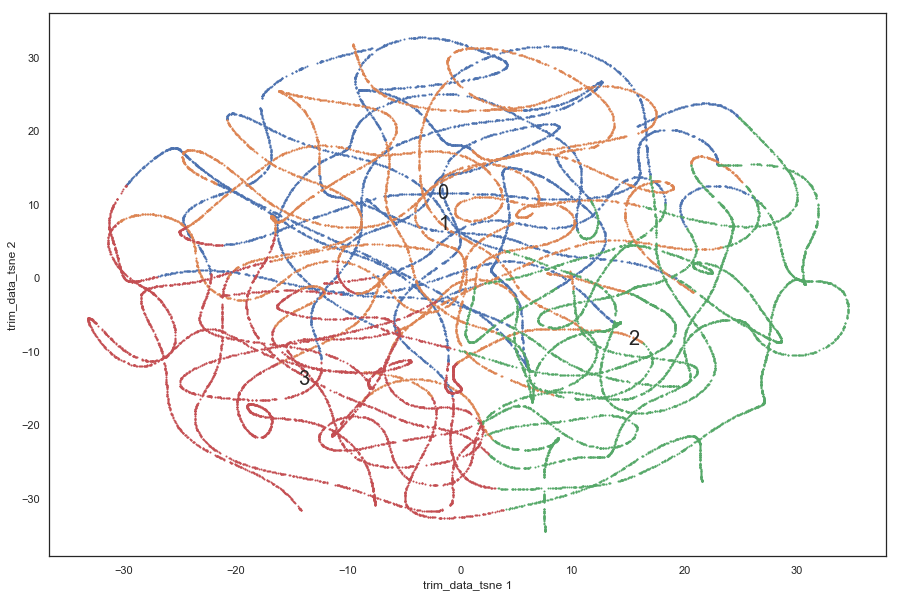

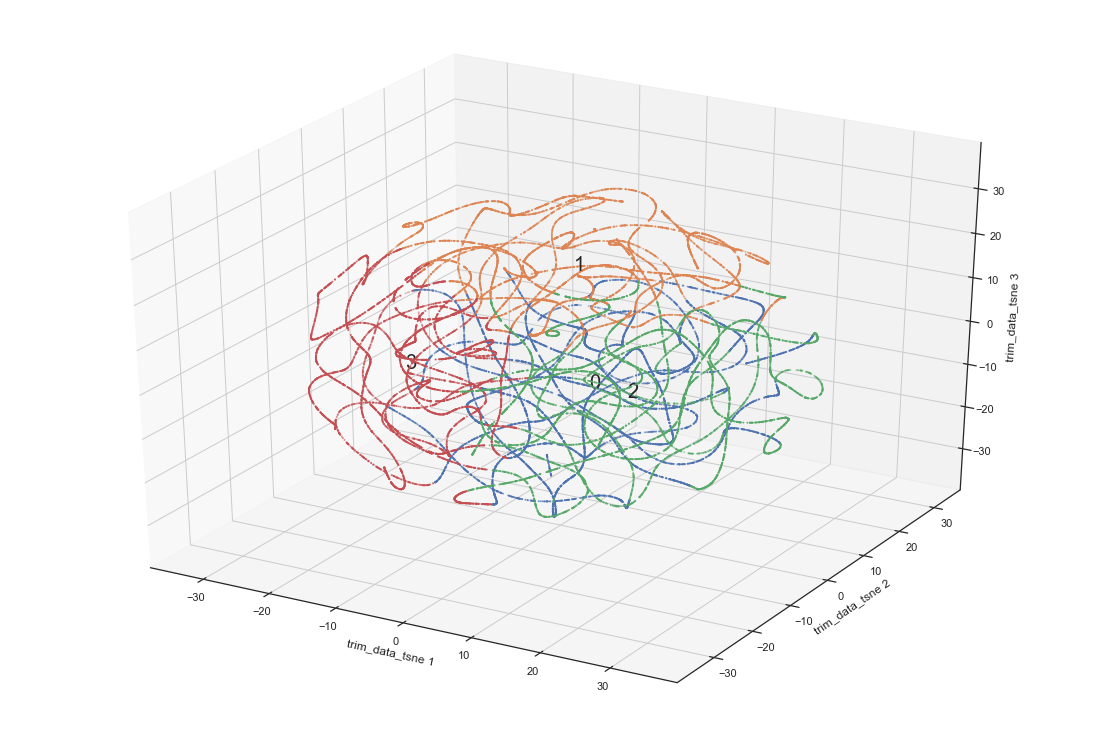

cosine  euclidean
Average for all Clusters  0.428545   0.246182

cosine  euclidean
cluster_id                     
0           0.402890   0.231832
1           0.411862   0.241541
2           0.431200   0.249817
3           0.475304   0.264595

cosine  euclidean
Sum of Squares for all Clusters  0.743798   0.244507

In [51]:
plt.figure(figsize=(15, 10))

for cluster_id in np.unique(labels):
    d = np.where(cluster_id == labels)
    label = 'Cluster #' + str(cluster_id)
    plt.scatter(trim_data_tsne[:,0][d], trim_data_tsne[:,1][d], label=label, s=1)
    
plt.xlabel("trim_data_tsne 1")
plt.ylabel("trim_data_tsne 2")
for i in range(n_clusters):
    plt.text(centroids[:, 0][i], centroids[:, 1][i], i, fontsize=20)
plt.show()

fig = pyplot.figure(figsize=(15, 10))
ax = Axes3D(fig)

for cluster_id in np.unique(labels):
    d = np.where(cluster_id == labels)
    label = 'Cluster #' + str(cluster_id)
    ax.scatter(trim_data_tsne[:,0][d], trim_data_tsne[:,1][d],trim_data_tsne[:,2][d], label=label, s=1)
for i in range(n_clusters):
    ax.text(centroids[:, 0][i], centroids[:, 1][i],centroids[:, 2][i], i, fontsize=20)

ax.set_xlabel('trim_data_tsne 1')
ax.set_ylabel('trim_data_tsne 2')
ax.set_zlabel('trim_data_tsne 3')

pyplot.show()

display(avg_metrics)
display(per_cluster_metrics)
display(ss_metrics)

# b) AgglomerativeClustering: TSNE

In [52]:
best_agglomerative_model = (None, None, -1.0)

n_clusters = np.arange(2, 11, 1)

models = []

for n in n_clusters:
    models.append((AgglomerativeClustering, {"n_clusters": n}))

for i, (Model, kwargs) in enumerate(models):
    print(Model.__name__, kwargs)
    silhouette = 0.0
    model = Model(**kwargs)
    model.fit(trim_data_tsne)
    unique, counts = np.unique(model.labels_, return_counts=True)
    
    avg_metrics, _, _ = cluster_analysis(trim_data_tsne,model.labels_, per_cluster=False)
    silhouette_euclidean = avg_metrics['euclidean'][0]
    silhouette_cosine = avg_metrics['cosine'][0]
    
    silhouette = (2 * silhouette_euclidean * silhouette_cosine) / (silhouette_euclidean + silhouette_cosine) # harmonic mean
    if best_agglomerative_model[2] < silhouette:
        best_agglomerative_model = (model, kwargs, silhouette)
        n_clusters = silhouette
    print("Silhouette harmonic mean of euclidean and cosine: ", silhouette)

AgglomerativeClustering {'n_clusters': 2}
Silhouette harmonic mean of euclidean and cosine:  0.20556764807356906
AgglomerativeClustering {'n_clusters': 3}
Silhouette harmonic mean of euclidean and cosine:  0.21625952952536143
AgglomerativeClustering {'n_clusters': 4}
Silhouette harmonic mean of euclidean and cosine:  0.2580813442198632
AgglomerativeClustering {'n_clusters': 5}
Silhouette harmonic mean of euclidean and cosine:  0.22259522756345285
AgglomerativeClustering {'n_clusters': 6}
Silhouette harmonic mean of euclidean and cosine:  0.20698569971755368
AgglomerativeClustering {'n_clusters': 7}
Silhouette harmonic mean of euclidean and cosine:  0.20050827249941952
AgglomerativeClustering {'n_clusters': 8}
Silhouette harmonic mean of euclidean and cosine:  0.19658274210528143
AgglomerativeClustering {'n_clusters': 9}
Silhouette harmonic mean of euclidean and cosine:  0.19633205779313556
AgglomerativeClustering {'n_clusters': 10}
Silhouette harmonic mean of euclidean and cosine:  0.1

In [53]:
print("The best results were with the Agglomerative model: ", best_agglomerative_model[1])
print("The results obtained: ")
print("Silhouette harmonic mean of euclidean and cosine", best_agglomerative_model[2])

The best results were with the Agglomerative model:  {'n_clusters': 4}
The results obtained: 
Silhouette harmonic mean of euclidean and cosine 0.2580813442198632


In [54]:
avg_metrics['cosine'].values[0]

0.23230502009391785

In [55]:
n_clusters=best_agglomerative_model[1]['n_clusters']
cls = AgglomerativeClustering(n_clusters=n_clusters)
cls.fit(trim_data_tsne)
labels = cls.labels_
# centroids = cls.cluster_centers_
avg_metrics, ss_metrics, per_cluster_metrics = cluster_analysis(trim_data_tsne,labels)

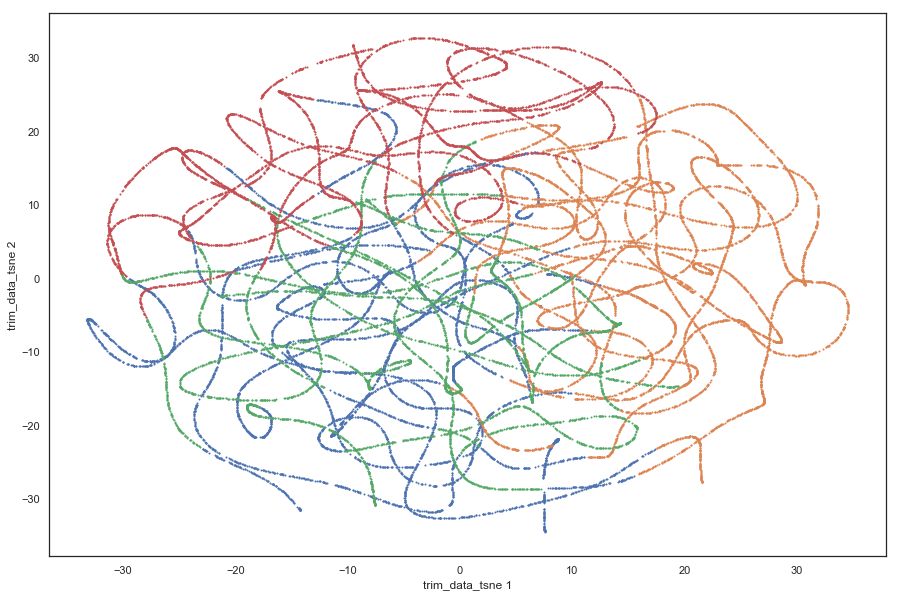

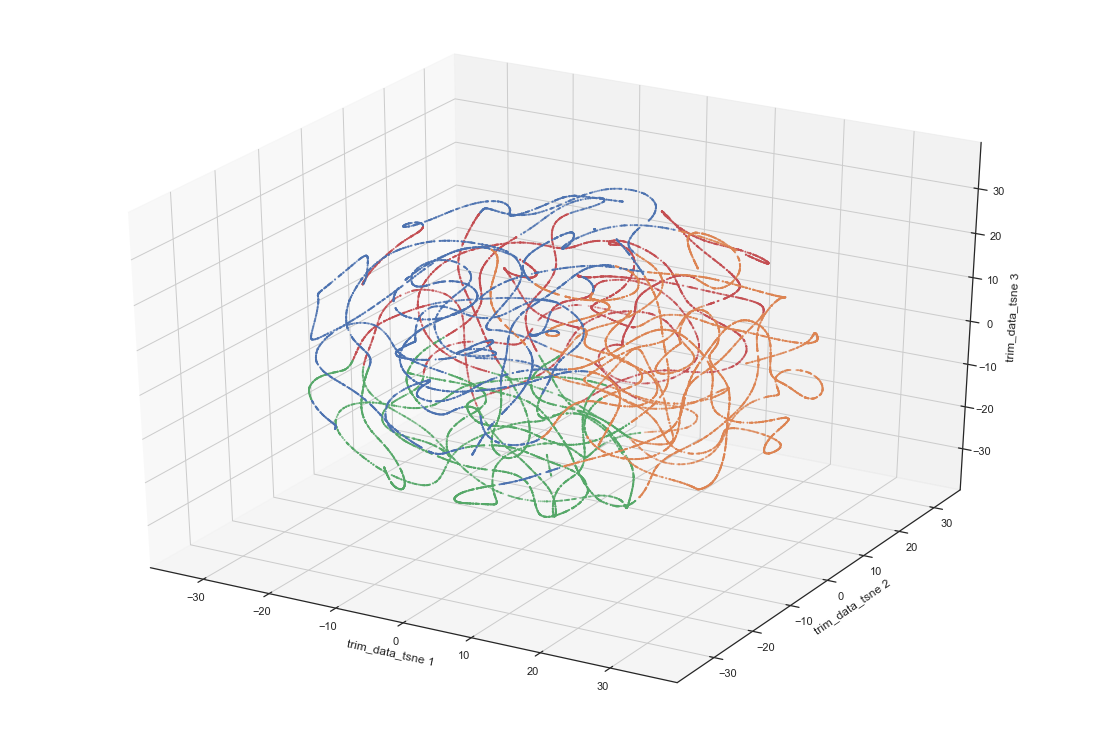

cosine  euclidean
Average for all Clusters  0.34196   0.207246

cosine  euclidean
cluster_id                     
0           0.275108   0.169800
1           0.256385   0.163630
2           0.443136   0.267463
3           0.438807   0.251487

cosine  euclidean
Sum of Squares for all Clusters  0.530339   0.190389

In [56]:
plt.figure(figsize=(15, 10))

for cluster_id in np.unique(labels):
    d = np.where(cluster_id == labels)
    label = 'Cluster #' + str(cluster_id)
    plt.scatter(trim_data_tsne[:,0][d], trim_data_tsne[:,1][d], label=label, s=1)
    
plt.xlabel("trim_data_tsne 1")
plt.ylabel("trim_data_tsne 2")
# for i in range(n_clusters):
#     plt.text(centroids[:, 0][i], centroids[:, 1][i], i, fontsize=20)
plt.show()

fig = pyplot.figure(figsize=(15, 10))
ax = Axes3D(fig)

for cluster_id in np.unique(labels):
    d = np.where(cluster_id == labels)
    label = 'Cluster #' + str(cluster_id)
    ax.scatter(trim_data_tsne[:,0][d], trim_data_tsne[:,1][d],trim_data_tsne[:,2][d], label=label, s=1)
# for i in range(n_clusters):
#     ax.text(centroids[:, 0][i], centroids[:, 1][i],centroids[:, 2][i], i, fontsize=20)

ax.set_xlabel('trim_data_tsne 1')
ax.set_ylabel('trim_data_tsne 2')
ax.set_zlabel('trim_data_tsne 3')

pyplot.show()

display(avg_metrics)
display(per_cluster_metrics)
display(ss_metrics)

# c) DBSCAN: TSNE

In [57]:
best_dbscan_model = (None, None, -1.0)

eps = np.arange(1, 2.1, 0.1)

models = []

for eps_val in eps:
    models.append((DBSCAN, {"eps": eps_val, "min_samples": 30}))

for i, (Model, kwargs) in enumerate(models):
    silhouette = 0.0
    model = Model(**kwargs)
    model.fit(trim_data_tsne)
    unique, counts = np.unique(model.labels_, return_counts=True)
    if len(dict(zip(unique, counts))) > 1:
        
        avg_metrics, _, _ = cluster_analysis(trim_data_tsne,model.labels_, per_cluster=False)
        silhouette_euclidean = avg_metrics['euclidean'][0]
        silhouette_cosine = avg_metrics['cosine'][0]
    
        silhouette = (2 * silhouette_euclidean * silhouette_cosine) / (silhouette_euclidean + silhouette_cosine) # harmonic mean
        if best_dbscan_model[2] < silhouette:
            best_dbscan_model = (model, kwargs, silhouette)
    print(Model.__name__, kwargs)
    print("Silhouette harmonic mean of euclidean and cosine: ", silhouette)

DBSCAN {'eps': 1.0, 'min_samples': 30}
Silhouette harmonic mean of euclidean and cosine:  -0.29684663586125276
DBSCAN {'eps': 1.1, 'min_samples': 30}
Silhouette harmonic mean of euclidean and cosine:  -0.6670874887306064
DBSCAN {'eps': 1.2000000000000002, 'min_samples': 30}
Silhouette harmonic mean of euclidean and cosine:  -0.713760623457639
DBSCAN {'eps': 1.3000000000000003, 'min_samples': 30}
Silhouette harmonic mean of euclidean and cosine:  -0.49880007874558707
DBSCAN {'eps': 1.4000000000000004, 'min_samples': 30}
Silhouette harmonic mean of euclidean and cosine:  0.20491955402136527
DBSCAN {'eps': 1.5000000000000004, 'min_samples': 30}
Silhouette harmonic mean of euclidean and cosine:  0.20597953370607167
DBSCAN {'eps': 1.6000000000000005, 'min_samples': 30}
Silhouette harmonic mean of euclidean and cosine:  -0.057098849195694114
DBSCAN {'eps': 1.7000000000000006, 'min_samples': 30}
Silhouette harmonic mean of euclidean and cosine:  0.02878154546154326
DBSCAN {'eps': 1.8000000000

In [58]:
print("The best results were with the DBSCAN model: ", best_dbscan_model[1])
print("The results obtained: ")
print("Silhouette harmonic mean of euclidean and cosine: ", best_dbscan_model[2])

The best results were with the DBSCAN model:  {'eps': 1.5000000000000004, 'min_samples': 30}
The results obtained: 
Silhouette harmonic mean of euclidean and cosine:  0.20597953370607167


In [59]:
eps=best_dbscan_model[1]['eps']
min_samples=best_dbscan_model[1]['min_samples']

cls = DBSCAN(eps=eps, min_samples=min_samples)
cls.fit(trim_data_tsne)
labels = cls.labels_
# centroids = cls.cluster_centers_
avg_metrics, ss_metrics, per_cluster_metrics = cluster_analysis(trim_data_tsne,labels)

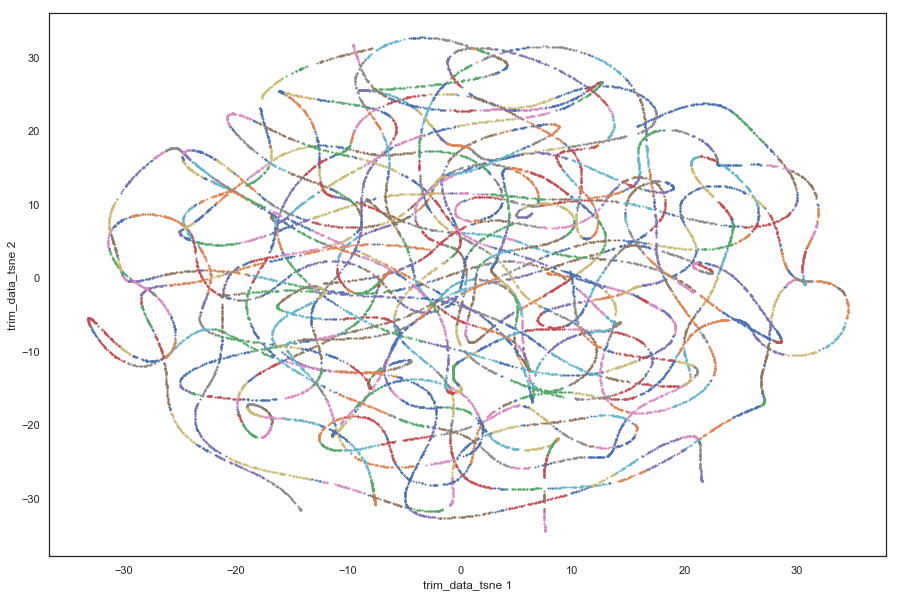

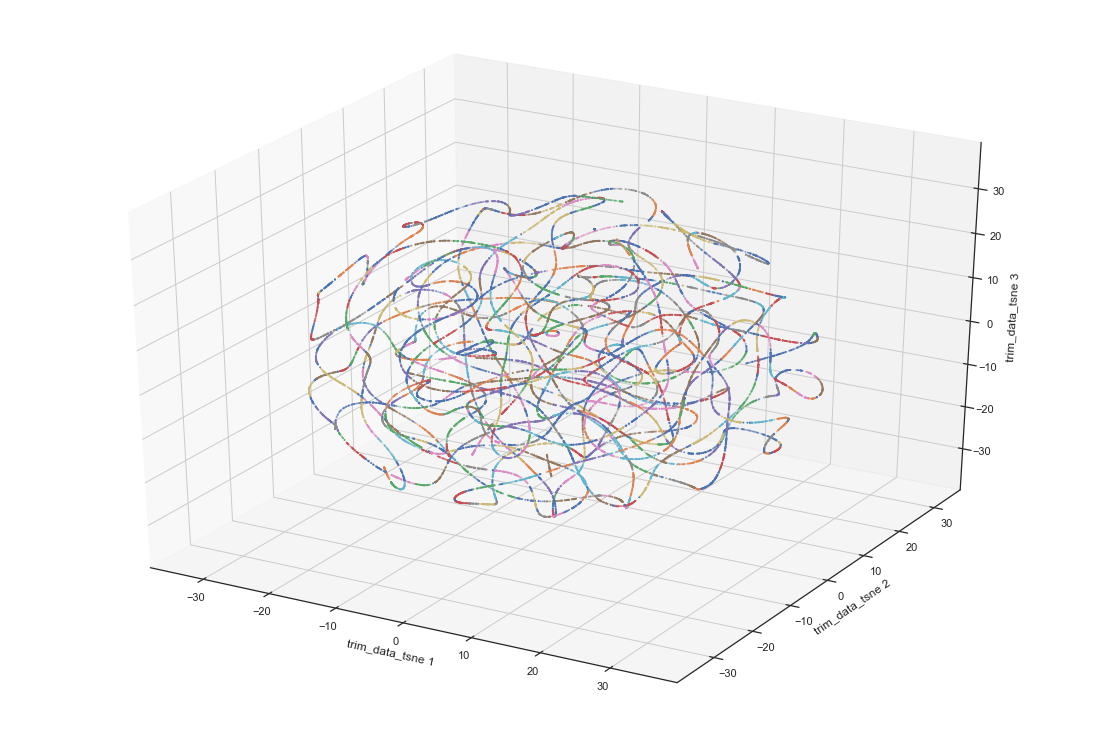

cosine  euclidean
Average for all Clusters  0.137749   0.408141

cosine  euclidean
cluster_id                     
-1         -0.996687  -0.906489
 0          0.111183   0.571297
 1         -0.335461   0.425964
 2          0.594070   0.692380
 3         -0.461155   0.612382
 4          0.299135   0.342540
 5          0.583679   0.505269
 6          0.458677   0.435177
 7          0.221170   0.540754
 8          0.806669   0.621253
 9          0.569018   0.602239
 10         0.126854   0.424932
 11         0.647224   0.485223
 12         0.557025   0.480569
 13         0.604762   0.625158
 14        -0.471189   0.441694
 15         0.805248   0.641757
 16         0.405437   0.639397
 17        -0.444241   0.393509
 18        -0.434967   0.639858
 19         0.006319   0.383018
 20         0.500867   0.355954
 21         0.404679   0.487927
 22         0.631374   0.626829
 23         0.291707   0.512333
 24         0.661439   0.541459
 25        -0.524432   0.319683
 26         0.356732   0.679282
 27        -0.830865   0.209998
 28        -0.548735   0.565145
...              ...        ...
 669        0.431806   0.712799
 670        0.412067   0.774278
 671        0.329118   0.210248
 672        0.962644   0.843641
 673        0.064012   0.517565
 674        0.311786   0.745579
 675        0.902797   0.818949
 676        0.882530   0.807393
 677        0.944588   0.815685
 678        0.947426   0.786171
 679       -0.181935   0.709840
 680        0.540073   0.538136
 681        0.941550   0.620831
 682        0.993060   0.920738
 683        0.923312   0.885952
 684        0.284501   0.799881
 685        0.923787   0.769345
 686        0.894305   0.751562
 687        0.781451   0.675799
 688        0.849893   0.666218
 689        0.855528   0.695228
 690        0.941162   0.786534
 691        0.940964   0.779527
 692        0.912700   0.828827
 693        0.804835   0.839808
 694        0.000000   0.000000
 695        0.920996   0.761304
 696        0.969163   0.826058
 697        0.790743   0.637631
 698        0.132339   0.643549

[700 rows x 2 columns]

cosine   euclidean
Sum of Squares for all Clusters  255.782963  253.258863

In [60]:
plt.figure(figsize=(15, 10))

for cluster_id in np.unique(labels):
    d = np.where(cluster_id == labels)
    label = 'Cluster #' + str(cluster_id)
    plt.scatter(trim_data_tsne[:,0][d], trim_data_tsne[:,1][d], label=label, s=1)
    
plt.xlabel("trim_data_tsne 1")
plt.ylabel("trim_data_tsne 2")
# for i in range(n_clusters):
#     plt.text(centroids[:, 0][i], centroids[:, 1][i], i, fontsize=20)
plt.show()

fig = pyplot.figure(figsize=(15, 10))
ax = Axes3D(fig)

for cluster_id in np.unique(labels):
    d = np.where(cluster_id == labels)
    label = 'Cluster #' + str(cluster_id)
    ax.scatter(trim_data_tsne[:,0][d], trim_data_tsne[:,1][d],trim_data_tsne[:,2][d], label=label, s=1)
# for i in range(n_clusters):
#     ax.text(centroids[:, 0][i], centroids[:, 1][i],centroids[:, 2][i], i, fontsize=20)

ax.set_xlabel('trim_data_tsne 1')
ax.set_ylabel('trim_data_tsne 2')
ax.set_zlabel('trim_data_tsne 3')

pyplot.show()

display(avg_metrics)
display(per_cluster_metrics)
display(ss_metrics)

# d) Hierarchical Clustering: TSNE

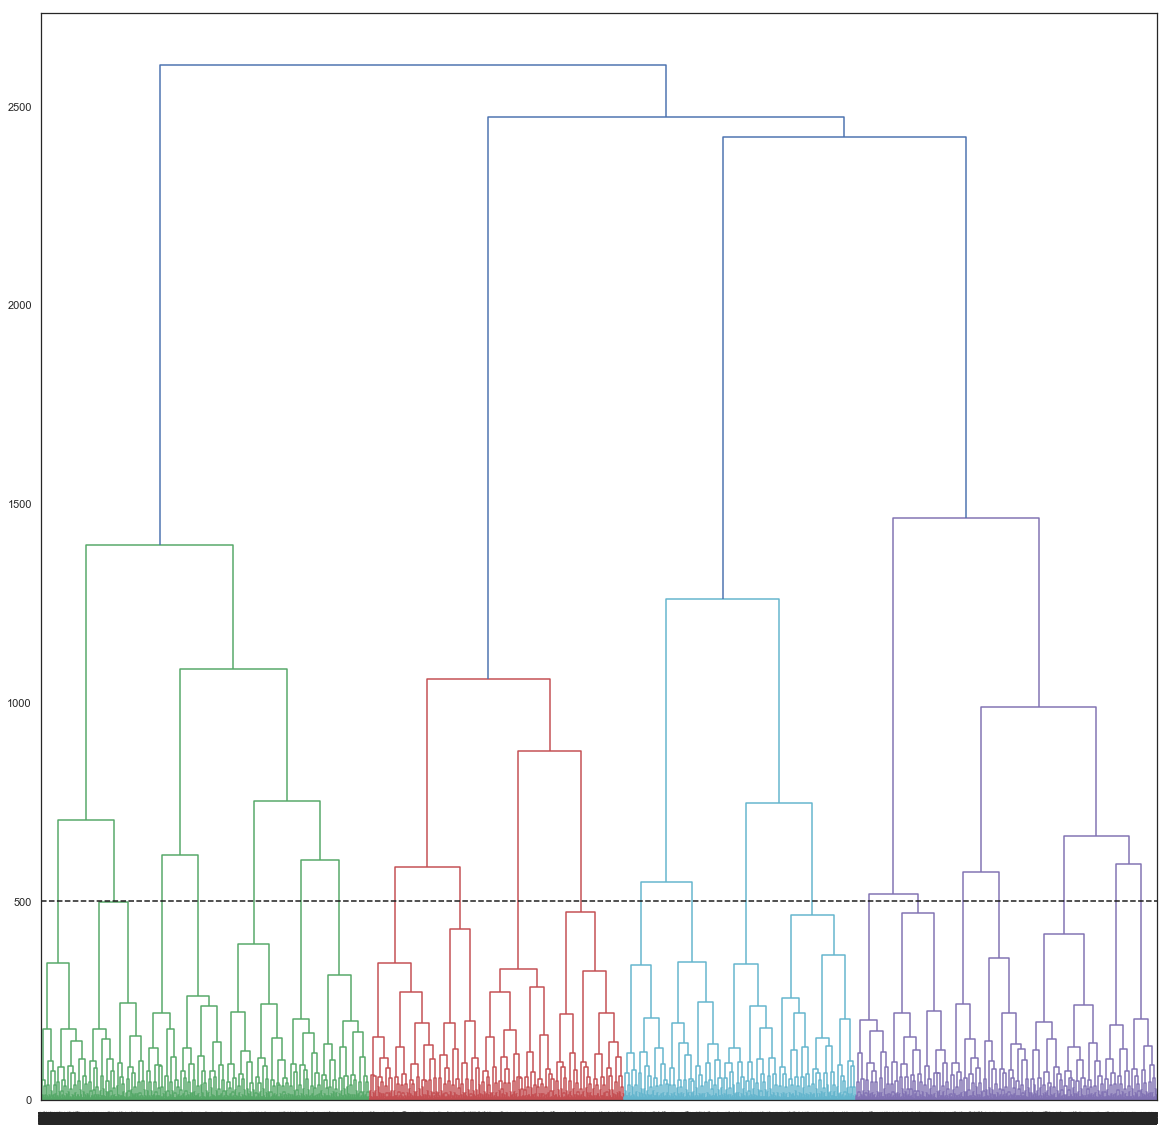

In [62]:
link = ward(trim_data_tsne)
sns.set(style='white')
plt.figure(figsize=(20,20))
dendrogram(link)
ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [500,500],'--', c='k')
plt.show()

# 2 TSNE Results:

After the number of clusters per algorithm was chosen by highest harmonic mean of euclidean and cosine silhouette score, the models are then compared to one another by the highest harmonic mean of euclidean and cosine silhouette score. The current subset looks like a protein nucleotide but had the full data been used, the clusters may have been more defined.

Depending on the run, MiniBatchKMeans yielded the highest silhouette score of 0.428545 cosine similarity and 0.246182 euclidean distance at 4 clusters. In another run, the cluster count is 6 depending on the subsetted data.

For this run, Agglomerative Clustering came in second with a silhouette score of 0.34196 cosine similarity and 0.207246 euclidean distance at 4 clusters. In another run, the optimal cluster count is 2.

DBSCAN clustering had a silhouette score of 0.137749 cosine similarity and 0.408141 euclidean distance at 700 clusters.

Hierarchical clustering suggests 19 clusters at 500, although it is quantitatively not applicable to assess.

# Overall results

To make sense of the dataset by cluster, one would bind the clustering label with the original dataset by row index and then group-by and/or sort by clustering label.

One can visually see how PCA clusters could be applied to the dataset. The addition of labels from the abstraction of the TSNE clusters would help make sense of the original dataset immensely.

PCA and TNSE are very different in data reduction. MiniBatchKMeans is the best algorithm with the highest silhouette score for PCA because of obvious clusters while MiniBatchKMeans is the best algorithm with the highest silhouette score for TSNE because of the simplest model works when the data reduced to strand-like connections. The simplest MiniBatchKMeans clustering algorithm is the best despite that other algorithms may work better in other circumstances.

# Winning Model: PCA classifier exploration

In [63]:
gc.collect()

cls = MiniBatchKMeans(n_clusters=3, random_state=0)
cls.fit(trim_data_pca)
labels = cls.labels_

In [64]:
resultpca = pd.concat([trim_data, pd.DataFrame(labels,columns=['label'])], axis=1)

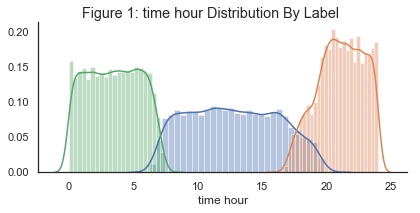

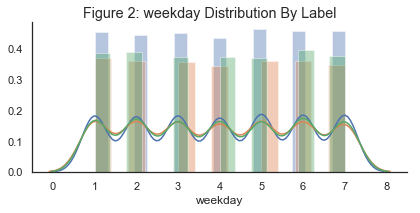

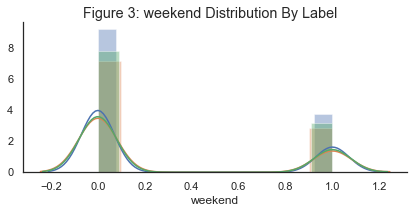

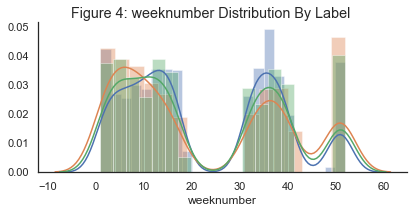

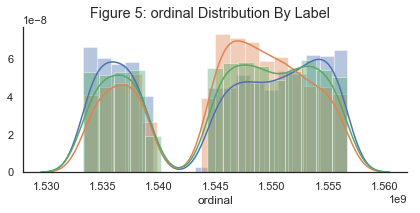

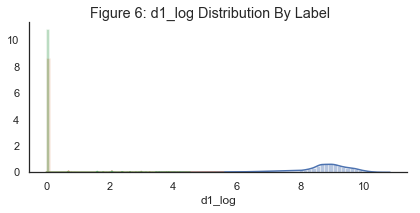

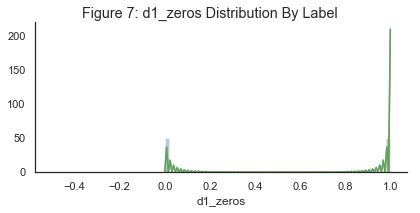

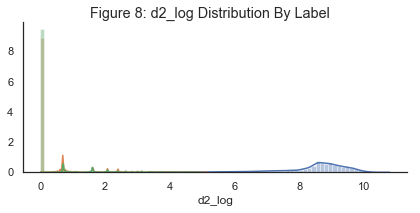

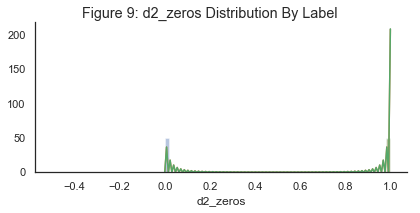

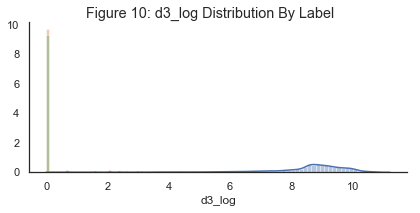

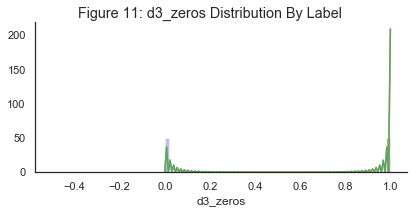

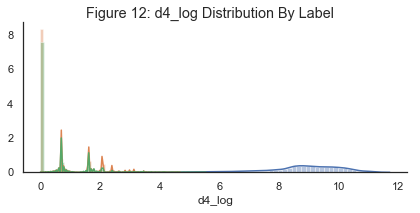

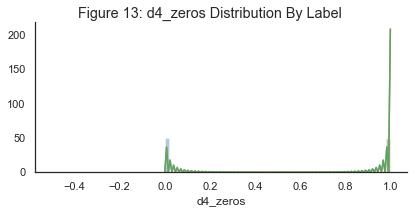

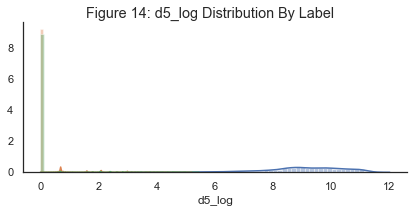

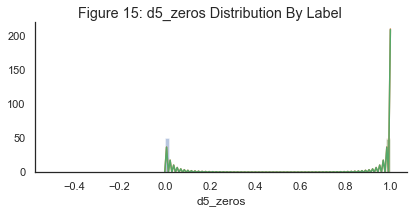

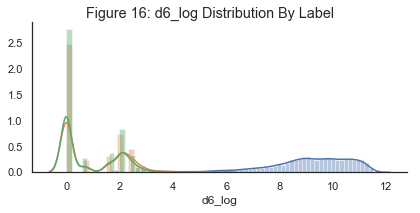

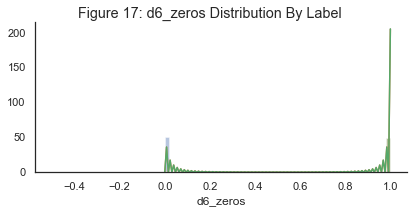

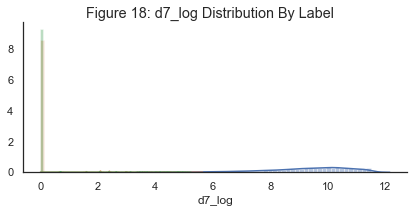

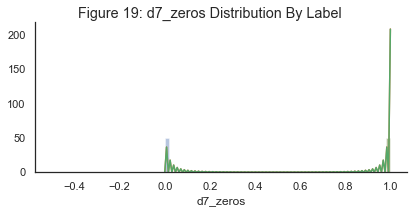

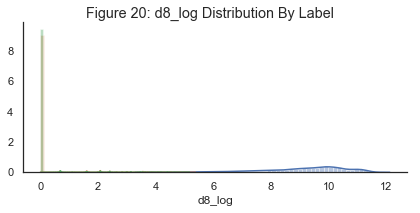

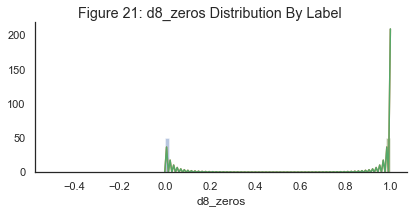

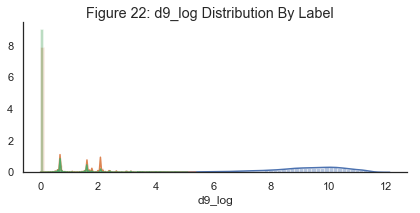

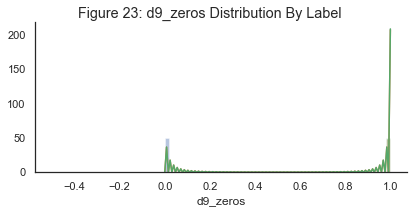

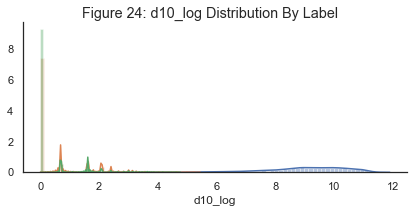

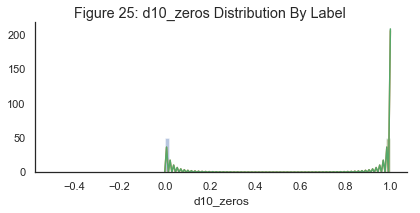

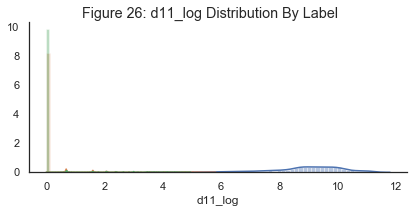

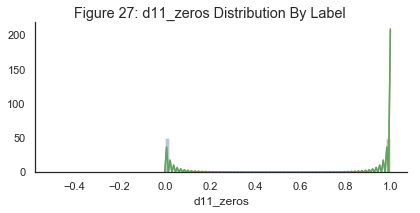

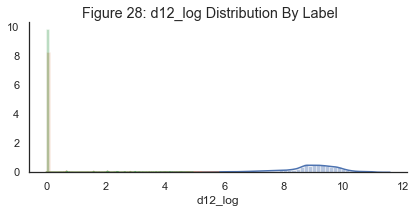

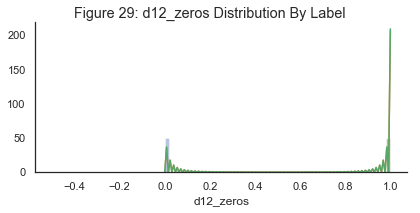

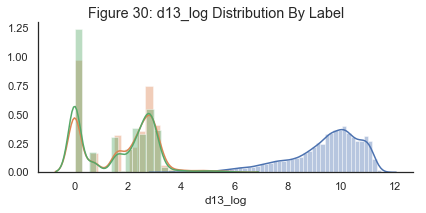

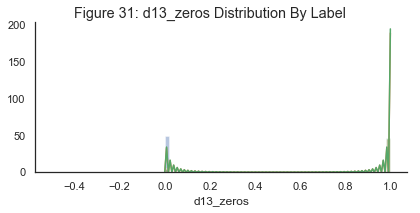

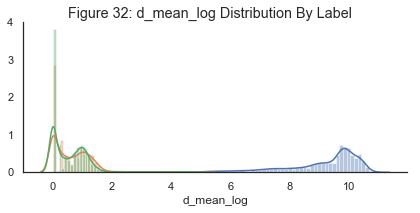

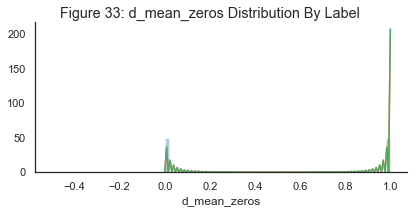

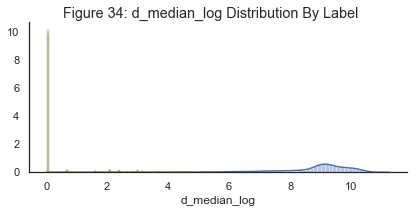

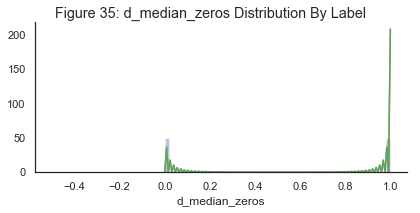

In [65]:
plt.rcParams['figure.max_open_warning']=40
colnames=list(resultpca.drop(columns='label').select_dtypes(exclude='O').columns.values)
for i in colnames[0:]:
    facet = sns.FacetGrid(resultpca,hue='label',aspect=2)
    facet.map(sns.distplot,i)
#     facet.add_legend()
    facet.fig.suptitle(''.join(map(str, list(["Figure ",colnames.index(i)+1,": ",i," Distribution By Label"]))))
    plt.show()

# Winning Model: TSNE classifier exploration

In [66]:
cls = MiniBatchKMeans(n_clusters=4, random_state=0)
cls.fit(trim_data_tsne)
labels = cls.labels_

In [67]:
resulttsne = pd.concat([trim_data, pd.DataFrame(labels,columns=['label'])], axis=1)

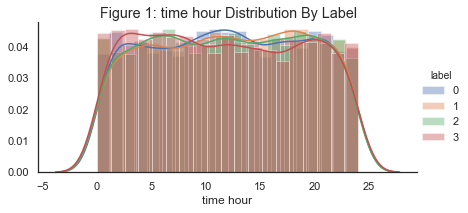

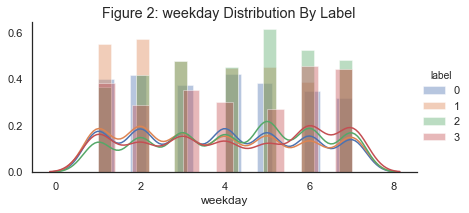

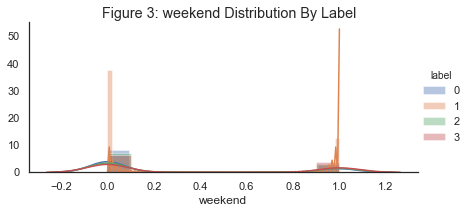

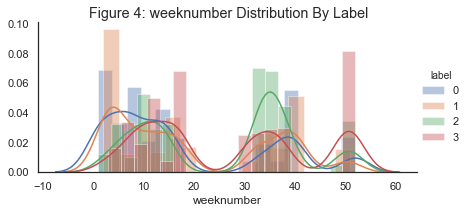

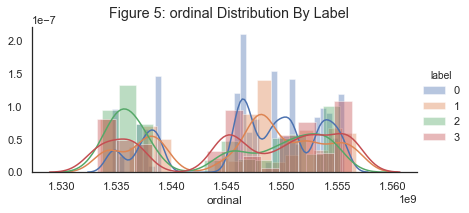

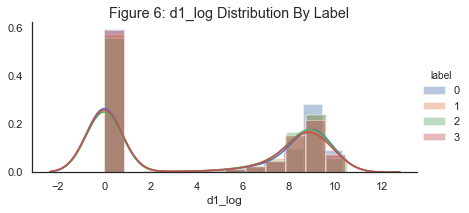

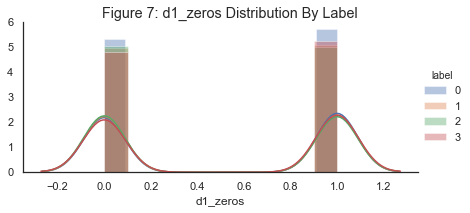

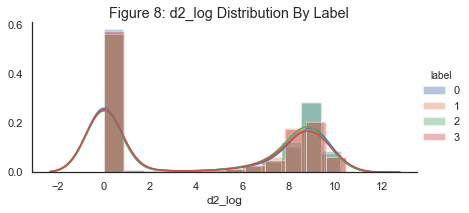

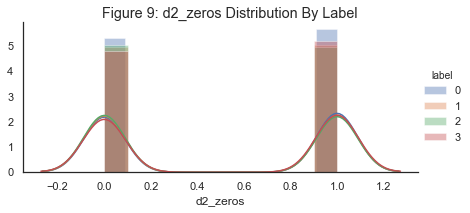

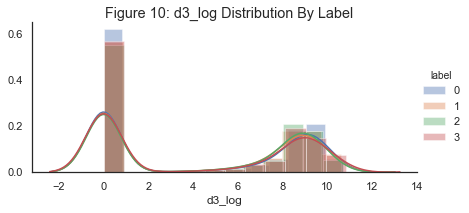

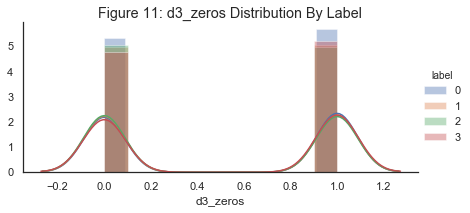

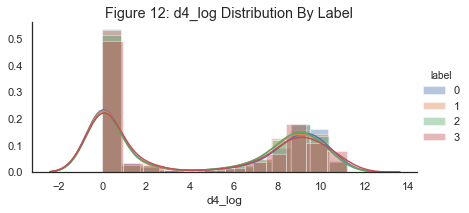

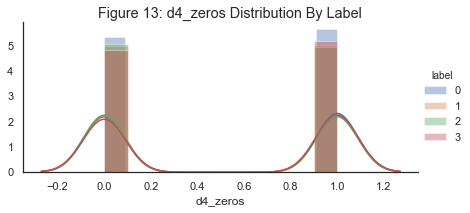

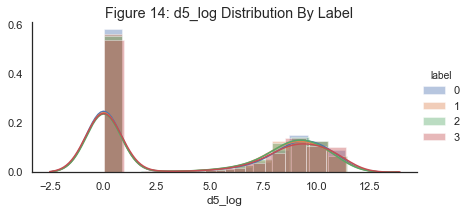

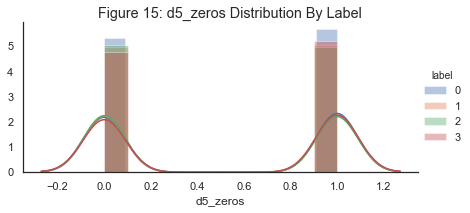

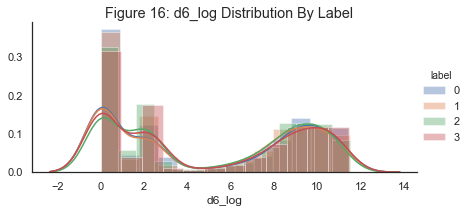

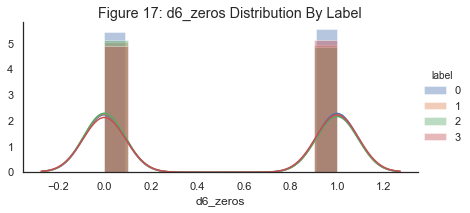

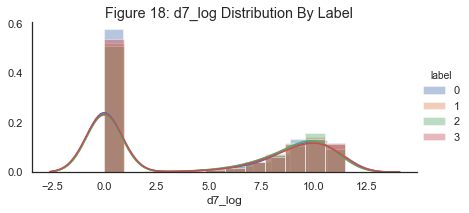

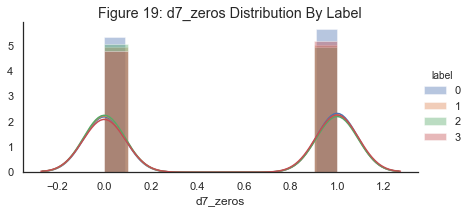

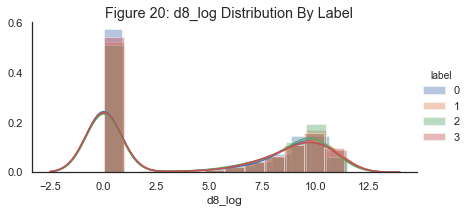

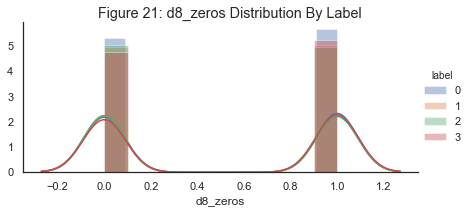

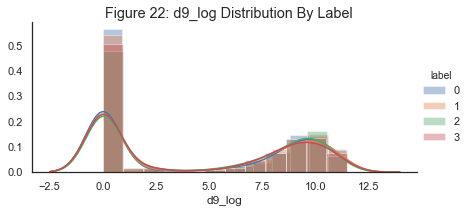

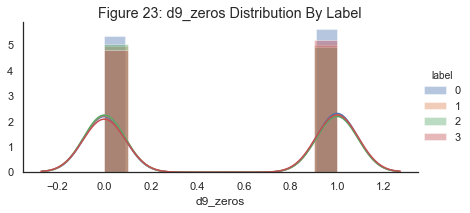

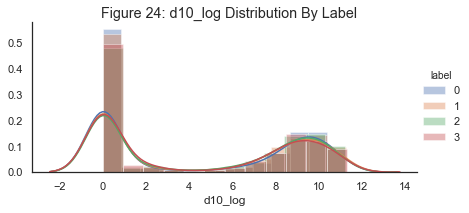

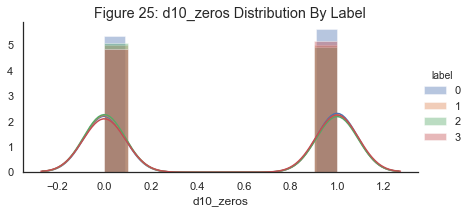

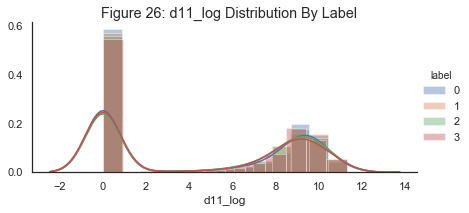

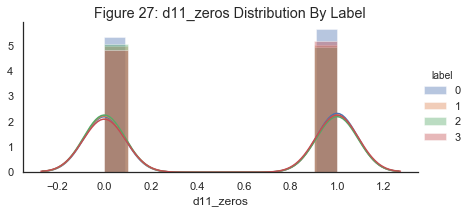

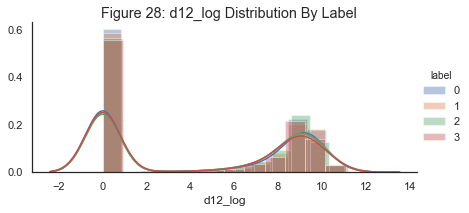

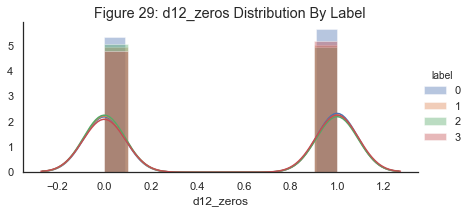

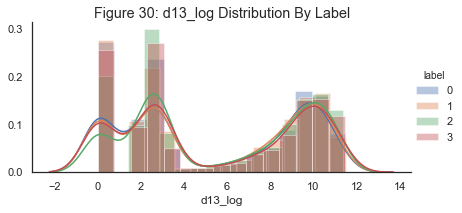

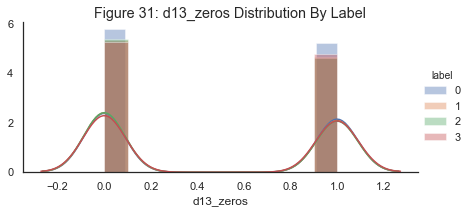

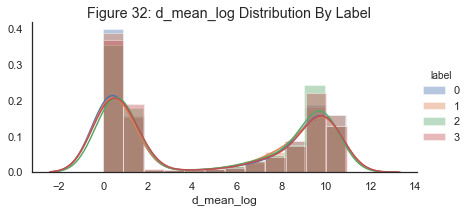

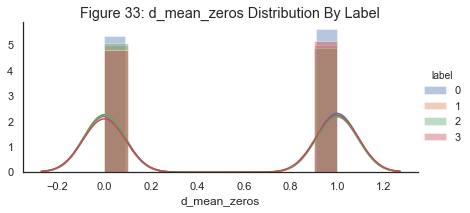

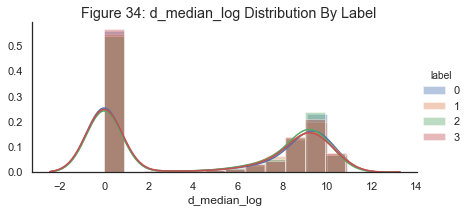

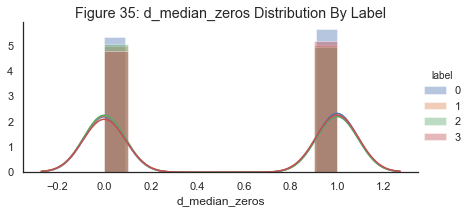

In [68]:
plt.rcParams['figure.max_open_warning']=40
colnames=list(resulttsne.drop(columns='label').select_dtypes(exclude='O').columns.values)
for i in colnames[0:]:
    facet = sns.FacetGrid(resulttsne,hue='label',aspect=2)
    facet.map(sns.distplot,i)
    facet.add_legend()
    facet.fig.suptitle(''.join(map(str, list(["Figure ",colnames.index(i)+1,": ",i," Distribution By Label"]))))
    plt.show()

# Unsupervised Classifier Results and Exploration

Here is what the original dataset looks like per classifier label for both PCA and TSNE applications of clustering. The application of PCA dimensionality reduction in this case makes more sense because the clusters are well defined intuitively versus that of TSNE when the original dataset is labeled by the clusters. The clusters of PCA from minibatch kmeans show that the clusters clearly are defined by the hour from midnight to sunrise, sunrise to sunset, and sunset to midnight while that of TSNE minibatch kmeans are still mixed together.

The minibatchkmeans clustering after PCA dimensionality reduction did the best for the shape of the 'horseshoe' because it allowed for simple discretization without the usage of more complex models that may perform better had the original shape of the dataset been more complex when plotted.